# 階層ベイズモデル　一般化線形混合モデル
ここでは階層ベイズモデルの基礎的な応用としての一般化線形混合モデル(GLMM)について説明する。

In [43]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## ベイズモデリングの階層化
ベイズモデリングでは、ある目的変数が従う分布のパラメータに対して事前分布を用意し、パラメータの事後分布を得ることを目的としている。例として、正規分布に従う次のようなモデルを考える。
$$
y_i \sim Normal(\mu, \sigma^2) \quad 確率モデル\\
\mu \sim Normal(\mu_0, \tau_0) \quad 平均の事前分布\\
1/\sigma^2 \sim halfCaucy(\nu_0/2, \nu_0\sigma_0^2/2) \quad 分散の事前分布
$$
グラフィカルモデルで表すと次のようになる。
この時、$\mu_0, \tau_0, \nu_0, \sigma_0^2$は事前分布のパラメータでハイパーパラメータという。ベイズモデルではこのハイパーパラメータを事前の知識に従って決めることで豊かな分析を行うことができる。

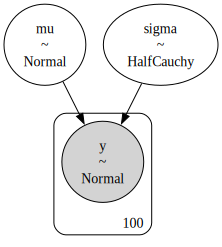

In [7]:
bayes_model = pm.Model()
with bayes_model:
    # 事前分布
    mu = pm.Normal('mu', mu=0, sigma=100)
    sigma = pm.HalfCauchy("sigma", beta=10)
    
    # 確率モデル
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=np.random.normal(0, 1, 100))
    
g = pm.model_to_graphviz(bayes_model)
display(g)

階層ベイスモデルでは、ハイパーパラメータに対しても事前分布を用意し、モデルを階層化していく。ハイパーパラメータ$\mu_0$に事前分布を用意したモデルは次のようになる。

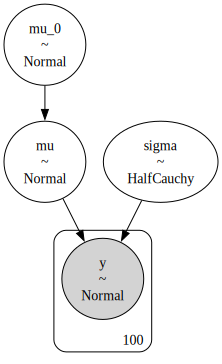

In [7]:
hierarchical_model = pm.Model()
with hierarchical_model:
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    # 事前分布
    mu = pm.Normal('mu', mu=mu_0, sigma=100)
    sigma = pm.HalfCauchy("sigma", beta=10)
    
    # 確率モデル
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=np.random.normal(0, 1, 100))
    
g = pm.model_to_graphviz(hierarchical_model)
display(g)

このように階層化することで、グループ間の差異によって平均が変化するようなモデルを考えることができる。

## 一般化線形混合モデル
一般化線形混合モデル(GLMM)は一般化線形モデルに変量効果(ランダム効果)を追加したもので、各個体やグループ間での差異をモデル化できる。ここではまず釣果データについてGLMMでモデル化する。

### データの説明

In [321]:
fish_nums = pd.read_csv('../data/3-1-fish-num.csv')

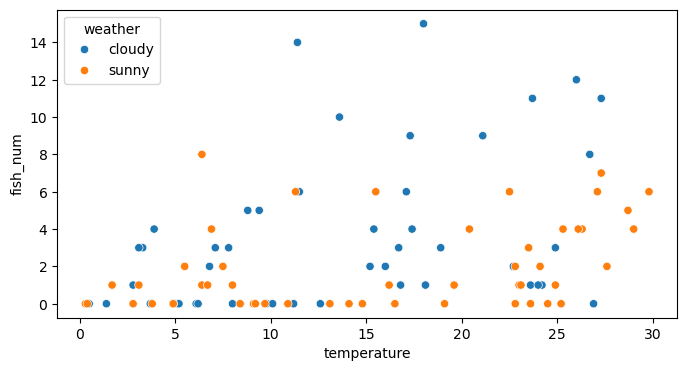

In [322]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
sns.scatterplot(x='temperature', y='fish_num', data=fish_nums, hue="weather", ax=axes)
plt.show()

ここで、通常のポアソンモデルによるモデル化を考える。

In [327]:
y = fish_nums['fish_num'].values
temp = fish_nums['temperature'].values
sunny = (fish_nums.weather=="sunny").values.astype(int)

In [328]:
poisson_model = pm.Model()
with poisson_model:
    poisson_model.add_coord("data", values=range(len(fish_nums)), mutable=True)
    # X, Yの観測値をMutableDataとして定義
    temp_data = pm.MutableData('temp_data', temp, dims='data')
    sunny_data = pm.MutableData('sunny_data', sunny, dims='data')
    Y_data = pm.MutableData('Y_data', y, dims='data')

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)

    # 期待値lambdaの計算
    # pm.math.expによって線形予測子を非線形変換
    mu = pm.Deterministic("mu", pm.math.exp(w0 + w1 * sunny_data + w2 * temp_data), dims='data')

    # 観測値が従う確率分布の定義
    y_ = pm.Poisson('y', mu=mu, observed=Y_data, dims='data')
    
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=3000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, w2]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


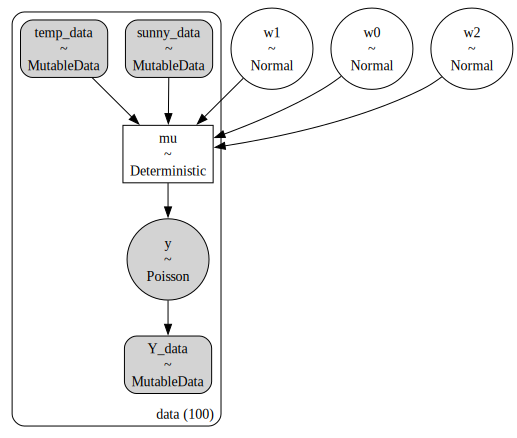

In [329]:
g = pm.model_to_graphviz(poisson_model)
display(g)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w0  0.293  0.152   0.017    0.589      0.003    0.002    3236.0    3699.0   
w1 -0.732  0.129  -0.978   -0.494      0.002    0.001    4494.0    4111.0   
w2  0.061  0.008   0.045    0.075      0.000    0.000    3138.0    3371.0   

    r_hat  
w0    1.0  
w1    1.0  
w2    1.0

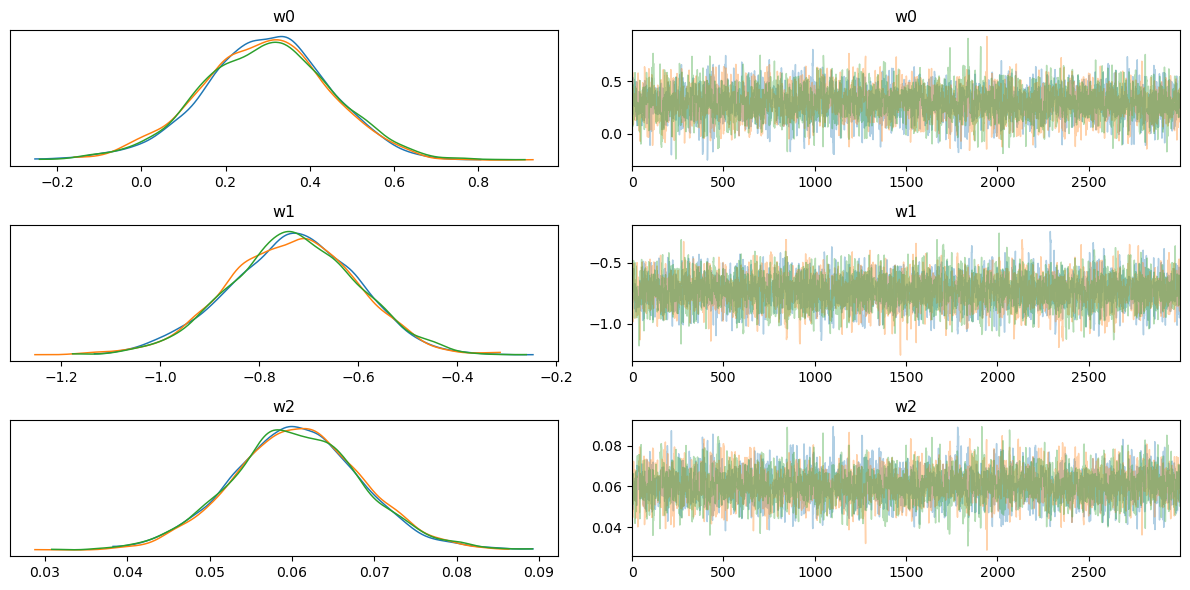

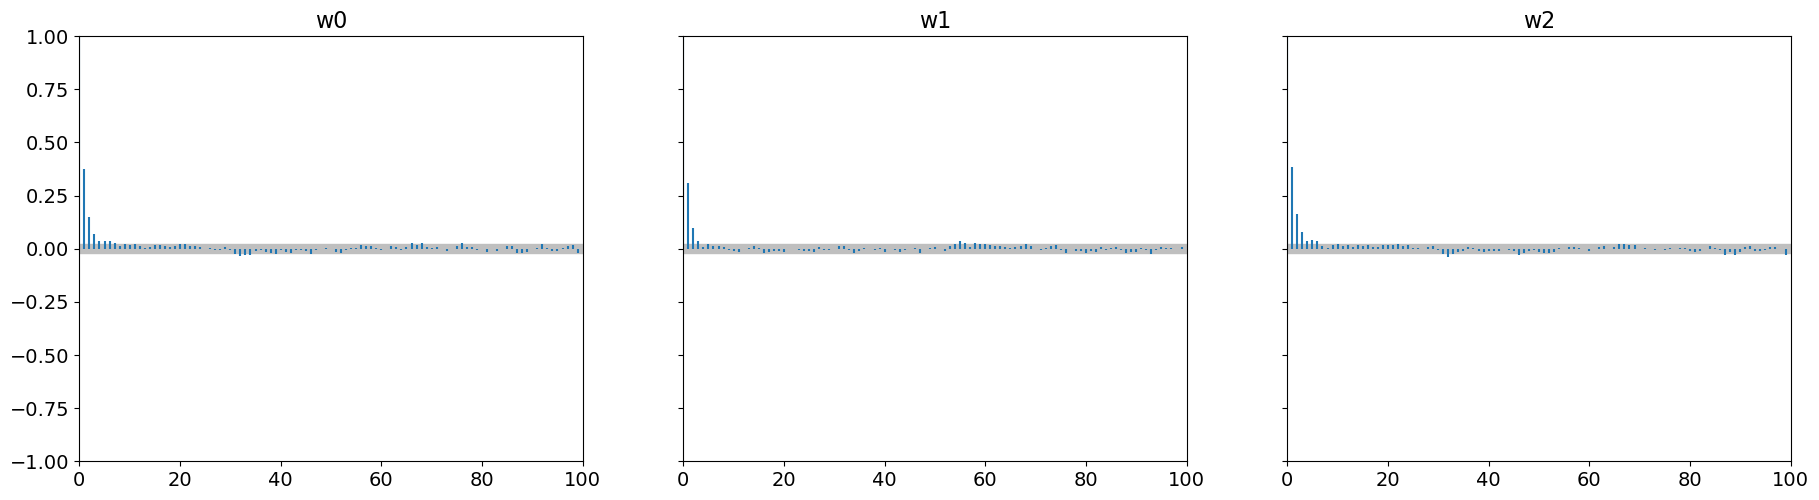

In [330]:
summary = az.summary(trace, var_names=["w0", "w1", "w2"])
display(summary)

az.plot_trace(trace, var_names=["w0", "w1", "w2"], compact=False)
plt.tight_layout()

az.plot_autocorr(trace, var_names=["w0", "w1", "w2"], combined=True)
plt.show()

In [128]:
temp_test = np.tile(np.linspace(temp.min(), temp.max(), 100), 2)
sunny_test = np.array([1] * 100 + [0] * 100)
sunny_idx = 100

In [127]:
pred_model = pm.Model()
with pred_model:
    pred_model.add_coord("data", values=range(len(temp_test)), mutable=True)
    # X, Yの観測値をMutableDataとして定義
    temp_data = pm.MutableData('temp_data', temp_test, dims='data')
    sunny_data = pm.MutableData('sunny_data', sunny_test, dims='data')
    #Y_data = pm.MutableData('Y_data', y, dims='data')

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)

    # 期待値lambdaの計算
    # pm.math.expによって線形予測子を非線形変換
    mu = pm.Deterministic("mu", pm.math.exp(w0 + w1 * sunny_data + w2 * temp_data))

    # 観測値が従う確率分布の定義
    y_pred = pm.Poisson('y_pred', mu=mu, dims='data')
    
    prediction = pm.sample_posterior_predictive(trace, var_names=["y_pred"], predictions=True).predictions

Sampling: [y_pred]


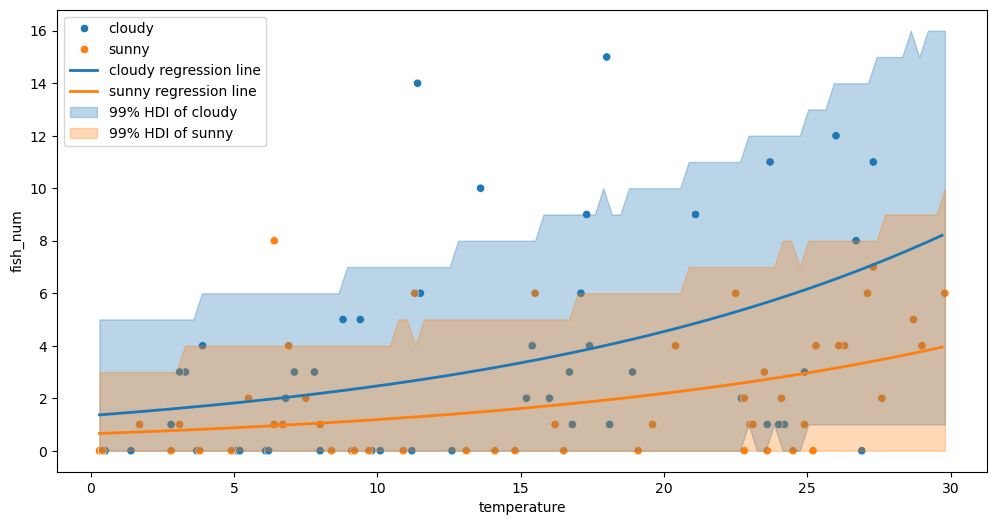

In [130]:
sunnies = fish_nums[fish_nums.weather == "sunny"]
cloudies = fish_nums[fish_nums.weather == "cloudy"]
temp_values = np.arange(temp.min(), temp.max(), 0.1)
cmap = plt.get_cmap("tab10")
# 平均回帰曲線の計算 指数関数で変換する
w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1
w2_mean = summary['mean'].w2
sunny_mean = np.exp(w0_mean + w1_mean + w2_mean * temp_values)
cloudy_mean = np.exp(w0_mean + w2_mean * temp_values)

# 各天気の気温データ
sunny_temp = temp_test[sunny_idx:]
cloudy_temp = temp_test[:sunny_idx]

# 各天気の予測分布の95% HDIの計算
hdis = az.hdi(prediction, hdi_prob=0.99)["y_pred"].values
hdi_sunny_pred = hdis[:sunny_idx]
hdi_cloudy_pred = hdis[sunny_idx:]


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.scatterplot(x='temperature', y='fish_num', data=fish_nums, hue="weather", ax=axes)    # 観測値の散布図

#各天気の回帰曲線
axes.plot(temp_values, cloudy_mean, lw=2, c=cmap(0), label='cloudy regression line')
axes.plot(temp_values, sunny_mean, lw=2, c=cmap(1), label='sunny regression line')

# 各天気の95% HDI
axes.fill_between(cloudy_temp, y1=hdi_cloudy_pred[:,0], y2=hdi_cloudy_pred[:,1], color=cmap(0), alpha=0.30, label="99% HDI of cloudy")
axes.fill_between(sunny_temp, y1=hdi_sunny_pred[:,0], y2=hdi_sunny_pred[:,1], color=cmap(1), alpha=0.30, label="99% HDI of sunny")
plt.legend()
plt.show()

単純なポアソンモデルによる99% HDIとデータを描写したところ、そこそこの数のデータがこの範囲から外れている。ポアソンモデルでは期待値と分散が$\lambda$という一つのパラメータのみで表されるが、今回はモデルの分散よりもデータの分散が大きかったと考えられる。これを過分散という。過分散はモデルに利用した説明変数の影響以外の影響が大きい時に起きる。今回では、気温と天気以外に個人の釣りの技術や釣り場の状況など観測されていない影響が考えられる。これらを考慮するためにGLMMを利用してモデルを改良する。

GLMでのモデルは次のように書ける。
$$
\lambda_i = \exp(w_0 + w_1x_{1i} + w_2x_{2i}) \\
y_i \sim Poisson(\lambda_i)
$$
GLMMでは、釣りの技術や釣り場の状況などサンプル取得時の調査のランダムな影響を$r_i$として導入する。GLMMでのモデルは次のように書ける。
$$
r_i \sim Normal(0, \sigma_r^2) \\
\lambda_i = \exp(w_0 + w_1x_{1i} + w_2x_{2i} + r_i) \\
y_i \sim Poisson(\lambda_i)
$$

$w_0, w_1, w_2$のようなある変数の影響を記述する効果を固定効果という。一方、何らかの確率分布に従ってランダムに変化する効果をランダム効果(変量効果)という。

### pymcでの実装

In [336]:
y = fish_nums['fish_num'].values
temp = fish_nums['temperature'].values
sunny = (fish_nums.weather=="sunny").values.astype(int)

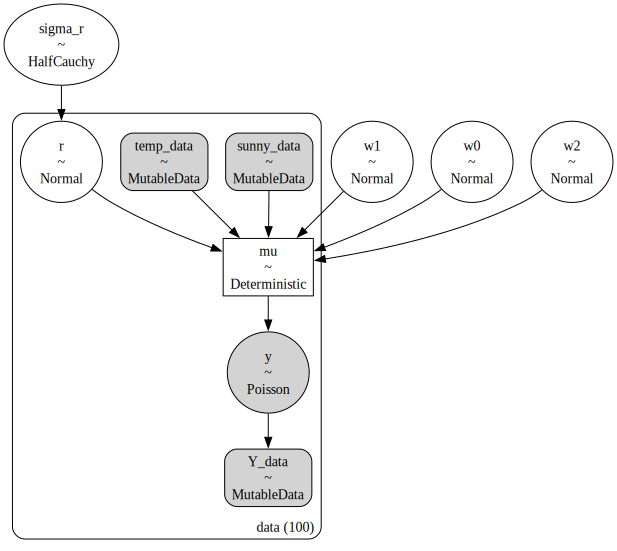

In [337]:
poisson_mix_model = pm.Model()
with poisson_mix_model:
    poisson_mix_model.add_coord("data", values=range(len(fish_nums)), mutable=True)
    # X, Yの観測値をMutableDataとして定義
    temp_data = pm.MutableData('temp_data', temp, dims='data')
    sunny_data = pm.MutableData('sunny_data', sunny, dims='data')
    Y_data = pm.MutableData('Y_data', y, dims='data')

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)
    sigma_r = pm.HalfCauchy("sigma_r", beta=10)
    
    r = pm.Normal("r", mu=0, sigma=sigma_r, dims='data')

    # 期待値lambdaの計算
    # pm.math.expによって線形予測子を非線形変換
    mu = pm.Deterministic("mu", pm.math.exp(w0 + w1 * sunny_data + w2 * temp_data + r), dims='data')

    # 観測値が従う確率分布の定義
    y_ = pm.Poisson('y', mu=mu, observed=Y_data, dims='data')
    
g = pm.model_to_graphviz(poisson_mix_model)
display(g)

In [338]:
with poisson_mix_model:
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=3000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, w2, sigma_r, r]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w0      -0.453  0.340  -1.114    0.157      0.006    0.004    3242.0   
w1      -0.730  0.285  -1.251   -0.172      0.004    0.003    4688.0   
w2       0.076  0.017   0.043    0.109      0.000    0.000    3743.0   
sigma_r  1.097  0.151   0.826    1.386      0.003    0.002    1955.0   

         ess_tail  r_hat  
w0         5053.0    1.0  
w1         5568.0    1.0  
w2         5590.0    1.0  
sigma_r    3192.0    1.0

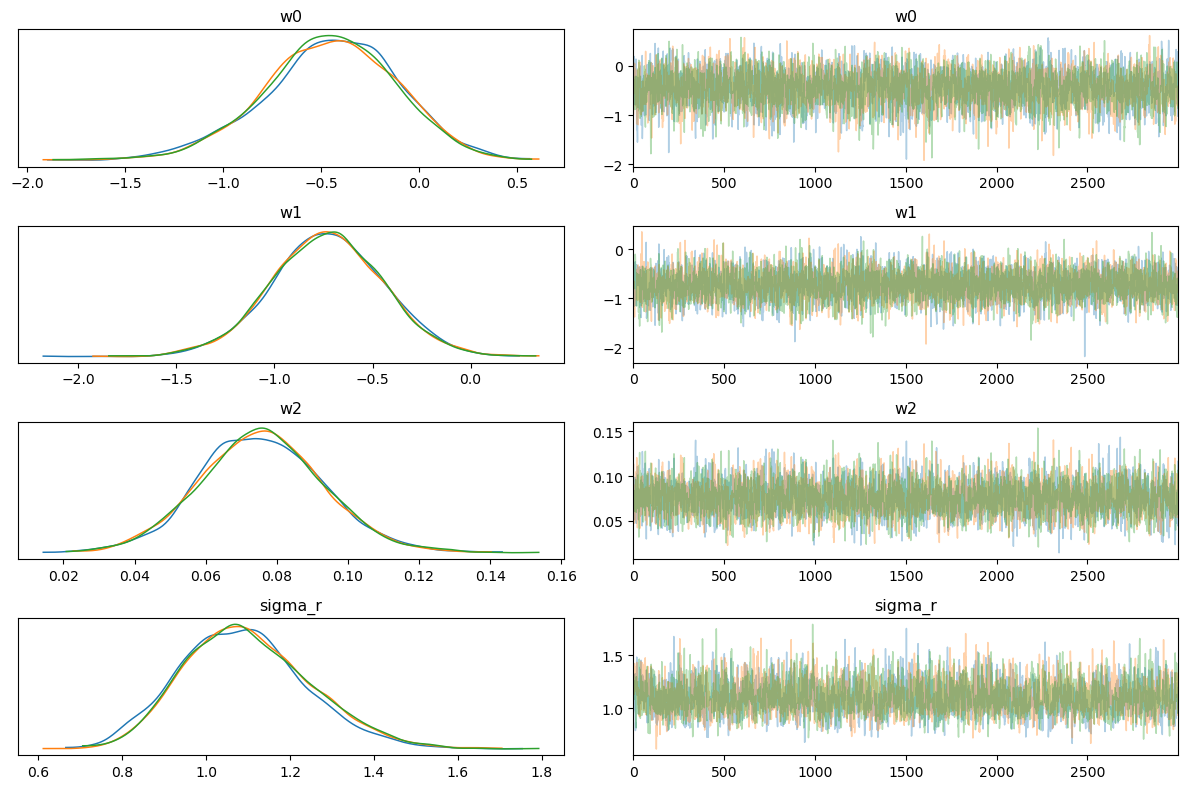

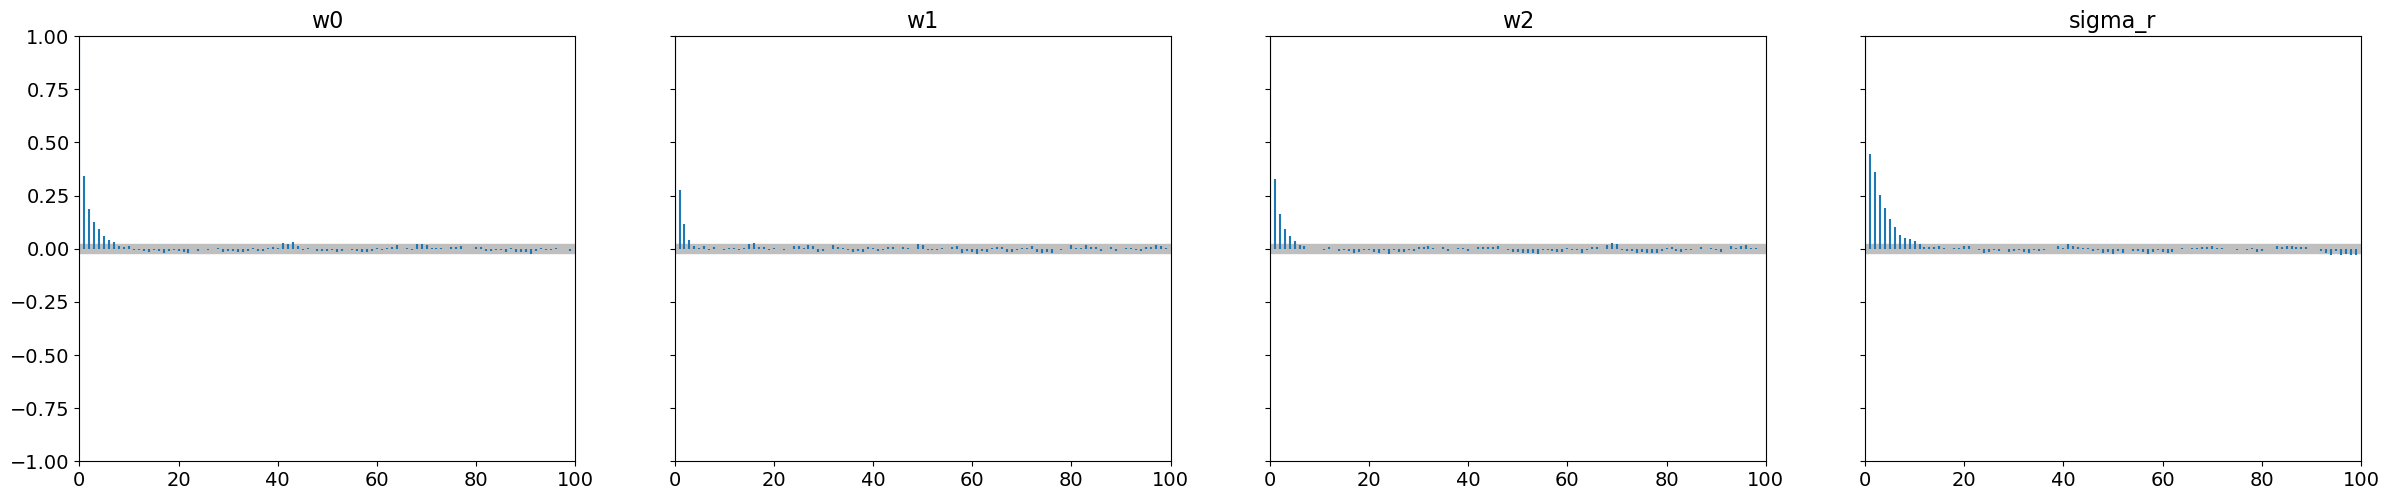

In [339]:
summary = az.summary(trace, var_names=["w0", "w1", "w2", "sigma_r"])
display(summary)

az.plot_trace(trace, var_names=["w0", "w1", "w2", "sigma_r"], compact=False)
plt.tight_layout()

az.plot_autocorr(trace, var_names=["w0", "w1", "w2", "sigma_r"], combined=True)
plt.show()

問題なく収束しているが、$\sigma_r$は少し収束しづらく、有効サンプル数が他よりも少ない。これはランダム効果は観測されていない影響を考慮したものであるため収束が難しいためである。

ここでは各データごとにランダム効果を割り当てたので曲線を引いて可視化することはできない。

### pystanでの実装

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
fish_nums = pd.read_csv('../data/3-1-fish-num.csv')

In [3]:
fish_nums

fish_num weather  temperature   id
0          0  cloudy          5.0    1
1          1  cloudy         24.2    2
2          6  cloudy         11.5    3
3          0  cloudy          9.8    4
4          1  cloudy         18.1    5
..       ...     ...          ...  ...
95         2   sunny          7.5   96
96         0   sunny          9.7   97
97         0   sunny          9.2   98
98         2   sunny          5.5   99
99         4   sunny         20.4  100

[100 rows x 4 columns]

In [4]:
y = fish_nums['fish_num'].values
temp = fish_nums['temperature'].values
weather = (fish_nums['weather']=="sunny").values.astype(int)
X = np.vstack([np.ones(len(y)), weather, temp]).T

In [7]:
temp_pred = np.tile(np.linspace(temp.min(), temp.max(), 100), 2)
sunny_pred = np.array([0] * 100 + [1] * 100)
X_pred = np.vstack([np.ones(len(temp_pred)), sunny_pred, temp_pred]).T

In [22]:
stan_data = {
    "N": len(y),
    "K": X.shape[1],
    "y": y,
    "X": X,
    "N_pred": len(temp_pred),
    "X_pred": X_pred
}

In [23]:
with open('../stan/3-1-1-glmm-overdispersion.stan') as f:
    stan_code = f.read()

In [24]:
sm = stan.build(stan_code, data=stan_data, random_seed=1)

Building...

In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Core:215,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Dense:1,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:22,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /root/.cache/httpstan/4.12.0/models/qpepfz32/model_qpepfz32.cpp:2:
/usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/src/Core/arch/NEON/PacketMath.h: In function ‘Packet Eigen::internal::pload(const typename unpacket_traits<T>::type*) [with Packet = eigen_packet_wrapper<int, 2>; typename unpacket_traits<T>::type = signed char]’:
/usr/local/lib/python3.11/


Building: 26.4s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [25]:
fit = sm.sample(num_chains=3, num_samples=6000, num_warmup=1000, num_thin=2)

Sampling:   0%
Sampling:   0% (1/21000)
Sampling:   0% (2/21000)
Sampling:   0% (102/21000)
Sampling:  34% (7101/21000)
Sampling:  67% (14100/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_gmcfrtdl/model_qpepfz32.stan', line 23, column 8 to column 31)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapf

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0] -0.462  0.342  -1.139    0.146      0.006    0.004    3322.0   
beta[1] -0.727  0.287  -1.270   -0.193      0.004    0.003    4563.0   
beta[2]  0.076  0.018   0.043    0.109      0.000    0.000    3733.0   
sigma_r  1.099  0.153   0.826    1.398      0.003    0.002    3056.0   

         ess_tail  r_hat  
beta[0]    5079.0    1.0  
beta[1]    6310.0    1.0  
beta[2]    5024.0    1.0  
sigma_r    5345.0    1.0

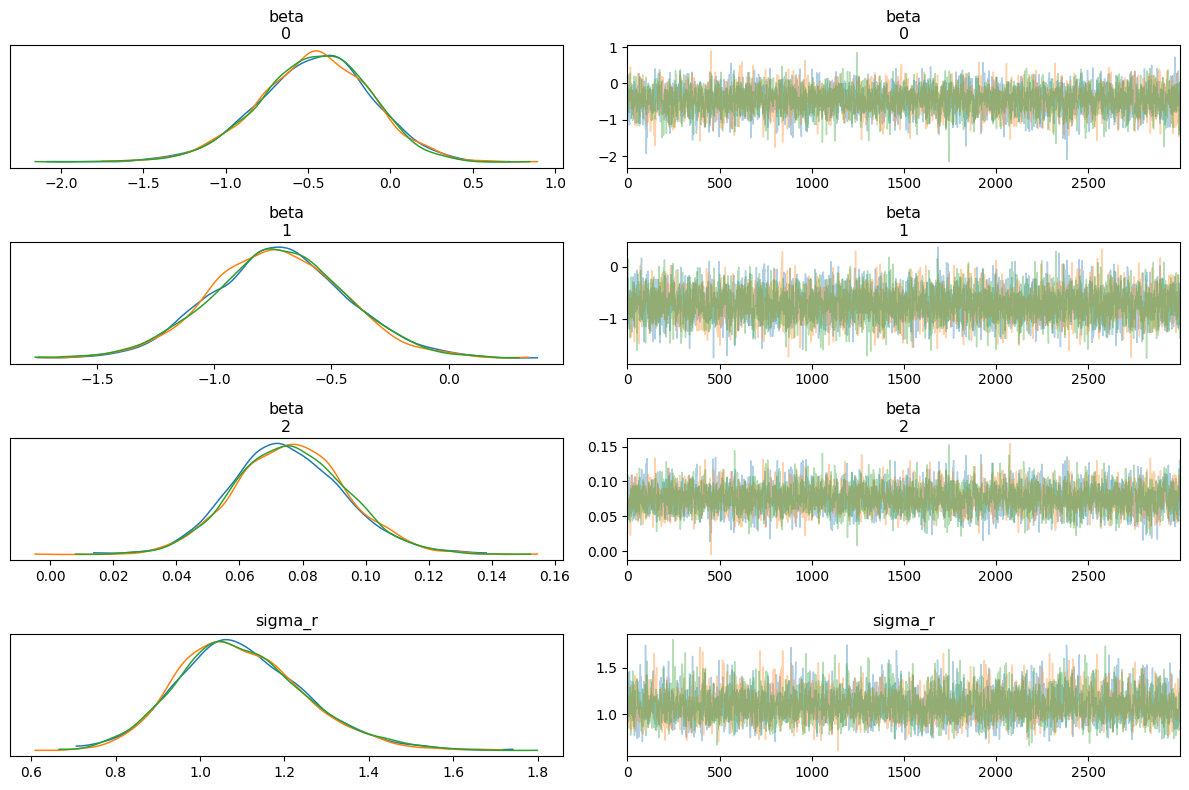

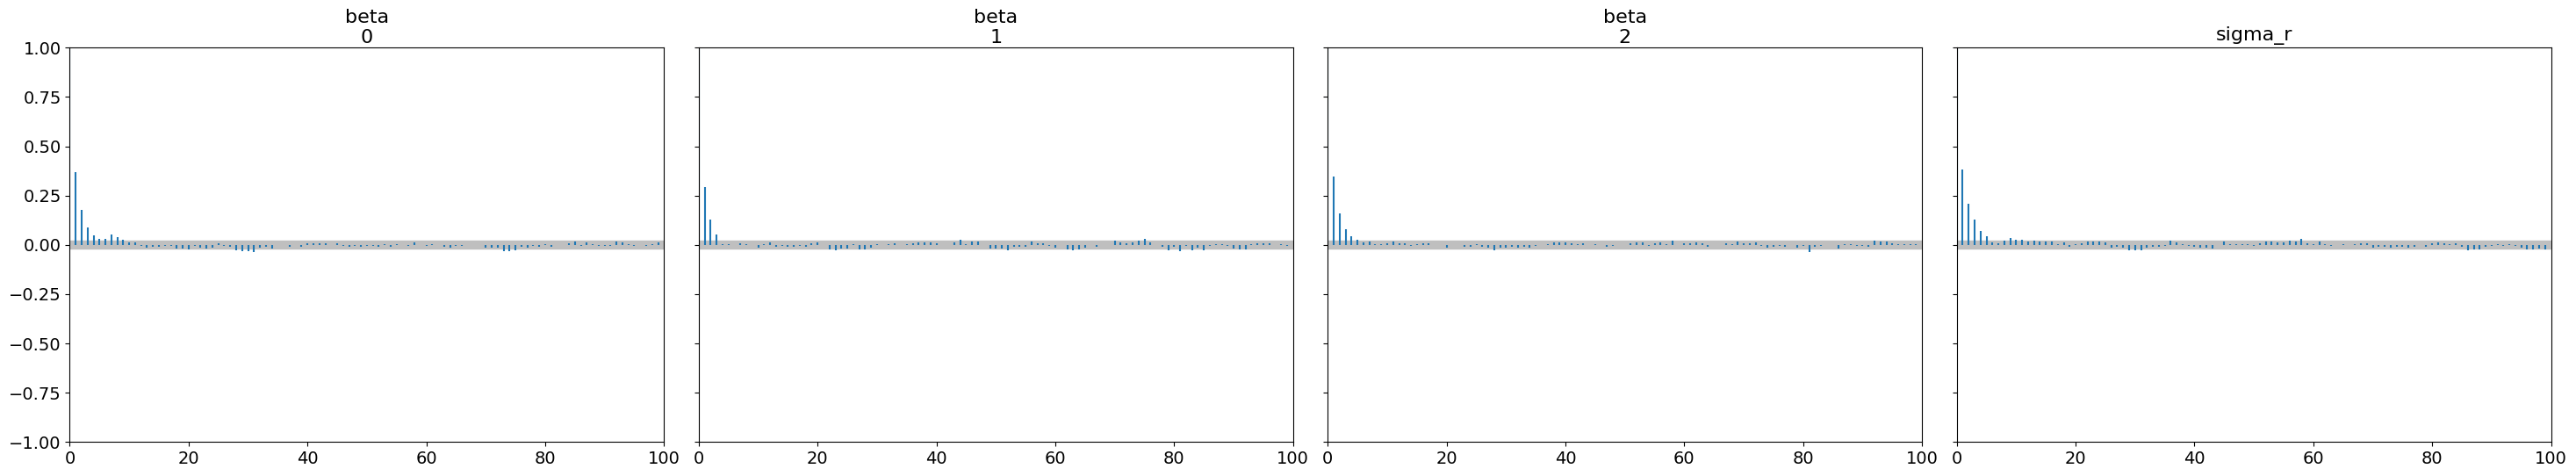

In [27]:
summary = az.summary(fit, var_names=["beta", "sigma_r"])
display(summary)
az.plot_trace(fit, var_names=["beta", "sigma_r"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["beta", "sigma_r"], combined=True)
plt.tight_layout()

## ランダム切片モデル
全てのデータにランダム効果を与えるのではなく、グループごとに異なるランダム効果を与えたい場合を考える。ここでは、釣果が天気と気温だけでなく釣り人の能力も考慮するモデルを考える。

### データの説明

In [340]:
fish_nums = pd.read_csv('../data/3-2-fish-num.csv')

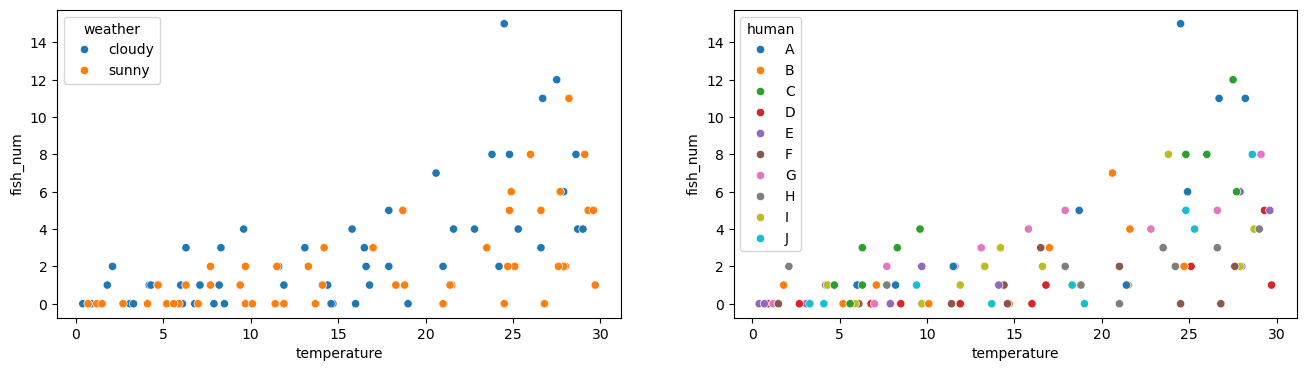

In [341]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
sns.scatterplot(x='temperature', y='fish_num', data=fish_nums, hue="weather", ax=axes[0])
sns.scatterplot(x='temperature', y='fish_num', data=fish_nums, hue="human", ax=axes[1])
plt.show()

このデータは天気と気温だけでなく、A~Jまでの釣り人のデータも入っている。釣り人の能力を考慮した上で気温と天気が釣果に与える影響を考える。この分析では、あくまで天気と気温が超過に与える影響を分析したいため、釣り人ごとの能力はランダム効果として与える。

このモデルは次のように書ける。
$$
r_k \sim Normal(0, \sigma_r^2) \\
\lambda_i = \exp(w_0 + w_1x_{1i} + w_2x_{2i} + r_k) \\
y_i \sim Poisson(\lambda_i)
$$
$k$はA~Jまでの10種類をとる。

### pymcでの実装

In [342]:
y = fish_nums['fish_num'].values
temp = fish_nums['temperature'].values
sunny = (fish_nums.weather=="sunny").values.astype(int)
human = pd.get_dummies(fish_nums['human']).values.astype(int)

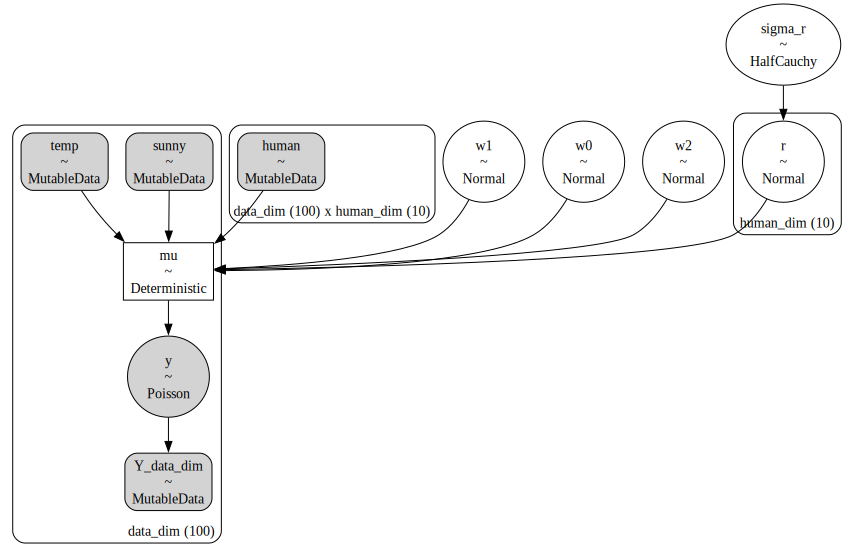

In [343]:
random_intercept_model = pm.Model()
with random_intercept_model:
    random_intercept_model.add_coord("data_dim", values=range(len(fish_nums)), mutable=True)
    random_intercept_model.add_coord("human_dim", values=range(human.shape[1]), mutable=True)
    # X, Yの観測値をMutableDataとして定義
    temp_data = pm.MutableData('temp', temp, dims='data_dim')
    sunny_data = pm.MutableData('sunny', sunny, dims='data_dim')
    human_data = pm.MutableData('human', human, dims=('data_dim', "human_dim"))
    Y_data = pm.MutableData('Y_data_dim', y, dims='data_dim')

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)
    sigma_r = pm.HalfCauchy("sigma_r", beta=10)
    
    r = pm.Normal("r", mu=0, sigma=sigma_r, dims='human_dim')

    # 期待値lambdaの計算
    # pm.math.expによって線形予測子を非線形変換
    mu = pm.Deterministic("mu", pm.math.exp(w0 + w1 * sunny_data + w2 * temp_data + pm.math.dot(human_data, r)), dims='data_dim')

    # 観測値が従う確率分布の定義
    y_ = pm.Poisson('y', mu=mu, observed=Y_data, dims='data_dim')
    
g = pm.model_to_graphviz(random_intercept_model)
display(g)

In [344]:
with random_intercept_model:
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=3000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, w2, sigma_r, r]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w0      -0.866  0.302  -1.456   -0.311      0.006    0.004    2744.0   
w1      -0.517  0.130  -0.757   -0.265      0.001    0.001   10560.0   
w2       0.097  0.009   0.080    0.114      0.000    0.000    8531.0   
sigma_r  0.637  0.208   0.305    1.017      0.003    0.002    5204.0   
r[0]     0.747  0.255   0.279    1.244      0.005    0.004    2249.0   
r[1]     0.080  0.292  -0.455    0.640      0.005    0.004    3267.0   
r[2]     0.685  0.260   0.208    1.192      0.005    0.004    2484.0   
r[3]    -0.616  0.334  -1.277   -0.029      0.005    0.004    4186.0   
r[4]    -0.125  0.294  -0.684    0.418      0.005    0.004    3296.0   
r[5]    -0.739  0.345  -1.373   -0.071      0.006    0.004    3661.0   
r[6]     0.441  0.271  -0.070    0.958      0.005    0.004    2607.0   
r[7]    -0.323  0.291  -0.859    0.230      0.005    0.004    3049.0   
r[8]     0.015  0.282  -0.531    0.533      0.005    0.004    2917.0   
r[9]    -0.176  0.294  -0.750    0.352      0.005    0.004    2962.0   

         ess_tail  r_hat  
w0         3861.0    1.0  
w1         6429.0    1.0  
w2         6905.0    1.0  
sigma_r    5425.0    1.0  
r[0]       3269.0    1.0  
r[1]       4112.0    1.0  
r[2]       3242.0    1.0  
r[3]       4882.0    1.0  
r[4]       4368.0    1.0  
r[5]       4825.0    1.0  
r[6]       3499.0    1.0  
r[7]       4009.0    1.0  
r[8]       4075.0    1.0  
r[9]       4027.0    1.0

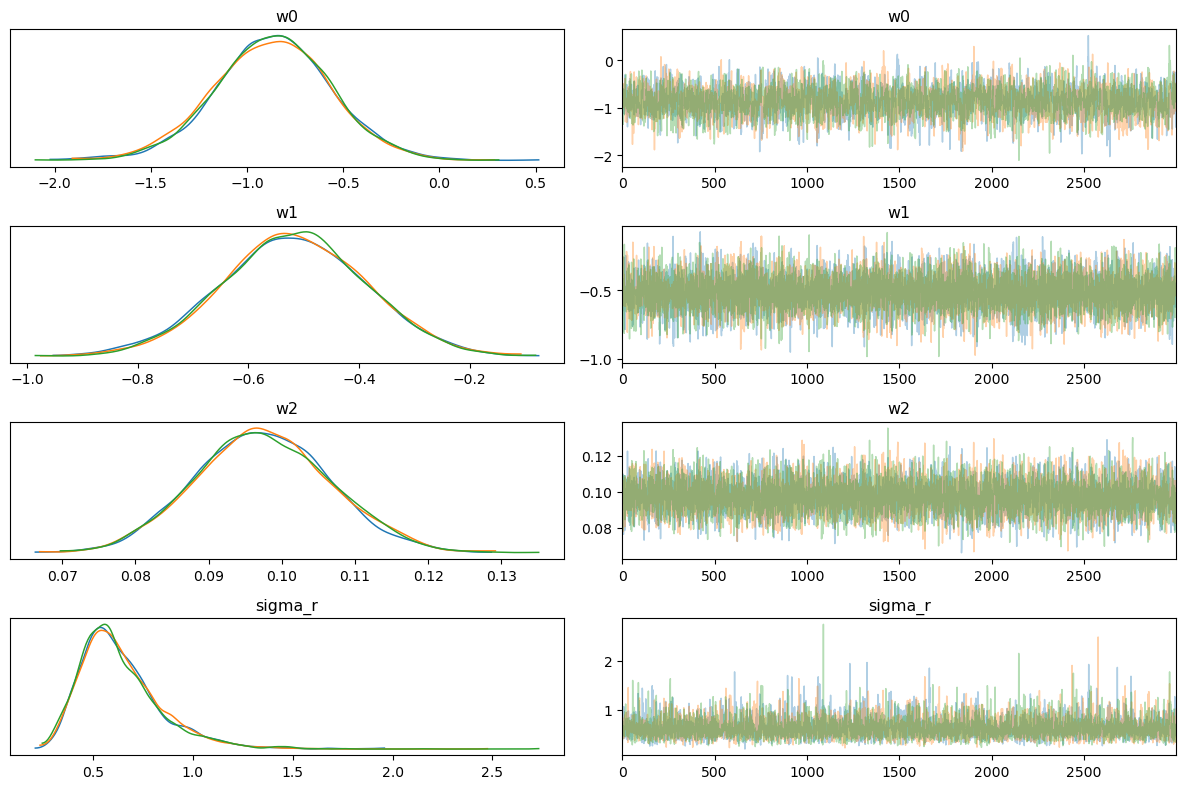

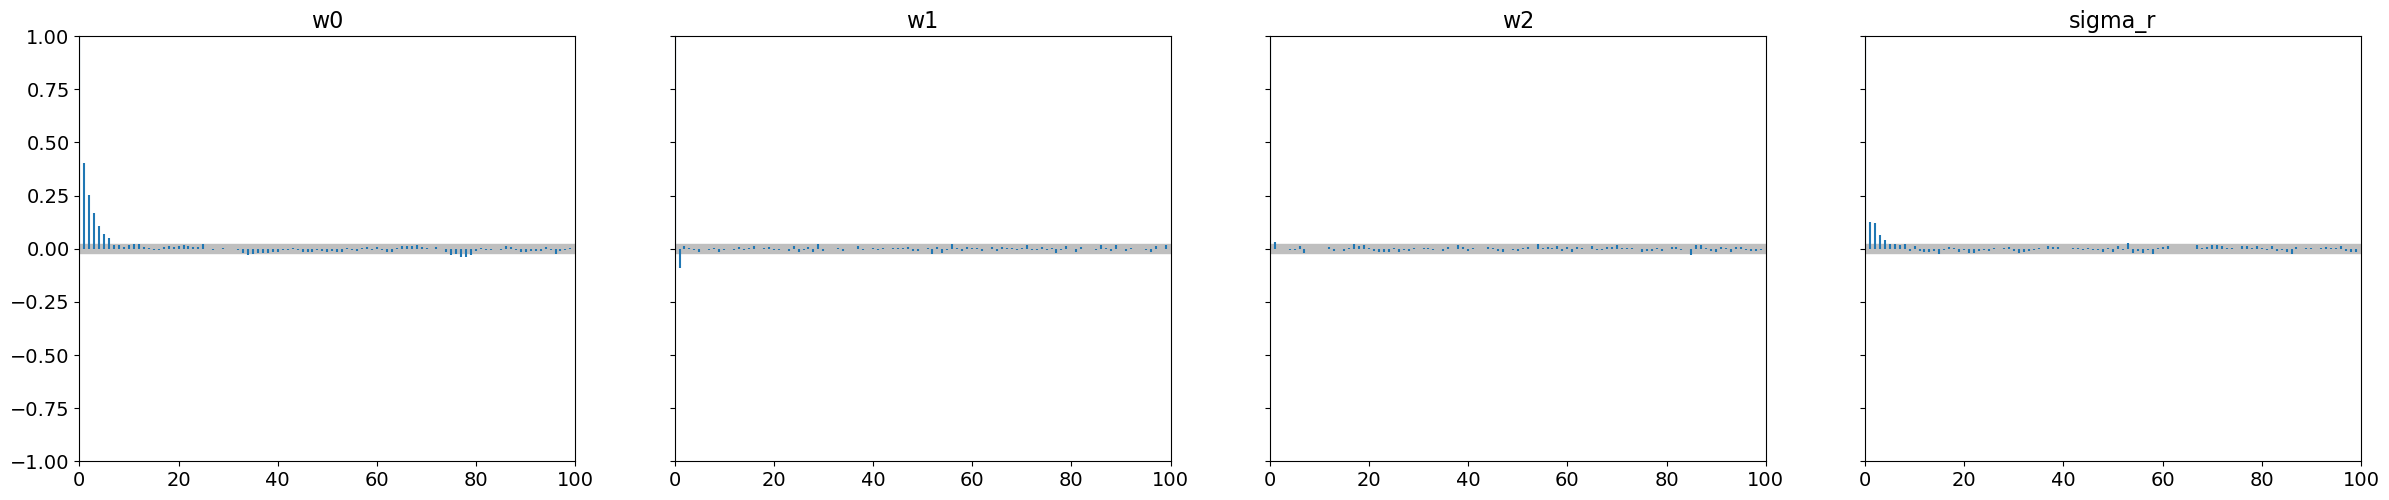

In [345]:
summary = az.summary(trace, var_names=["w0", "w1", "w2", "sigma_r", "r"])
display(summary)

az.plot_trace(trace, var_names=["w0", "w1", "w2", "sigma_r"], compact=False)
plt.tight_layout()

az.plot_autocorr(trace, var_names=["w0", "w1", "w2", "sigma_r"], combined=True)
plt.show()

全ての変数が収束している。ランダム効果$r$を見ると、ほとんどはHDIに0を含んでいるので多くの人が釣りが上手いわけでも下手なわけでもないが、$r_0, r_2$は$r$が正の値を取り、$r_3, r_5$は$r$が負の値をとる。そのため、A, Cさんは釣りが上手く、D, Fさんは釣りが下手だと言える。

#### 可視化
釣り人ごとに回帰曲線をプロットすることで釣り人の能力を考慮した可視化が可能になる。

In [346]:
temp_test = np.tile(np.linspace(temp.min(), temp.max(), 100), 10*2)
sunny_test = np.tile(np.array([1] * 100 + [0] * 100), 10)
human_test = pd.get_dummies(np.tile(fish_nums.human.unique(), (200,1)).T.flatten()).values.astype(int)

In [348]:
pred_model = pm.Model()
with pred_model:
    random_intercept_model.add_coord("data_dim", values=range(len(fish_nums)), mutable=True)
    random_intercept_model.add_coord("human_dim", values=range(human.shape[1]), mutable=True)
    
    # X, Yの観測値をMutableDataとして定義
    temp_data = pm.MutableData('temp', temp_test, dims='data_dim')
    sunny_data = pm.MutableData('sunny', sunny_test, dims='data_dim')
    human_data = pm.MutableData('human', human_test, dims=('data_dim', "human_dim"))

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w2 = pm.Normal("w2", mu=0, sigma=20)
    sigma_r = pm.HalfCauchy("sigma_r", beta=10)
    
    r = pm.Normal("r", mu=0, sigma=sigma_r, dims='human_dim')

    # 期待値lambdaの計算
    # pm.math.expによって線形予測子を非線形変換
    mu = pm.Deterministic("mu", pm.math.exp(w0 + w1 * sunny_data + w2 * temp_data + pm.math.dot(human_data, r)), dims='data_dim')

    # 観測値が従う確率分布の定義
    y_ = pm.Poisson('y_pred', mu=mu, observed=Y_data, dims='data_dim')
    
    prediction = pm.sample_posterior_predictive(trace, var_names=["y_pred", "mu"], predictions=True).predictions

Sampling: [r, y_pred]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


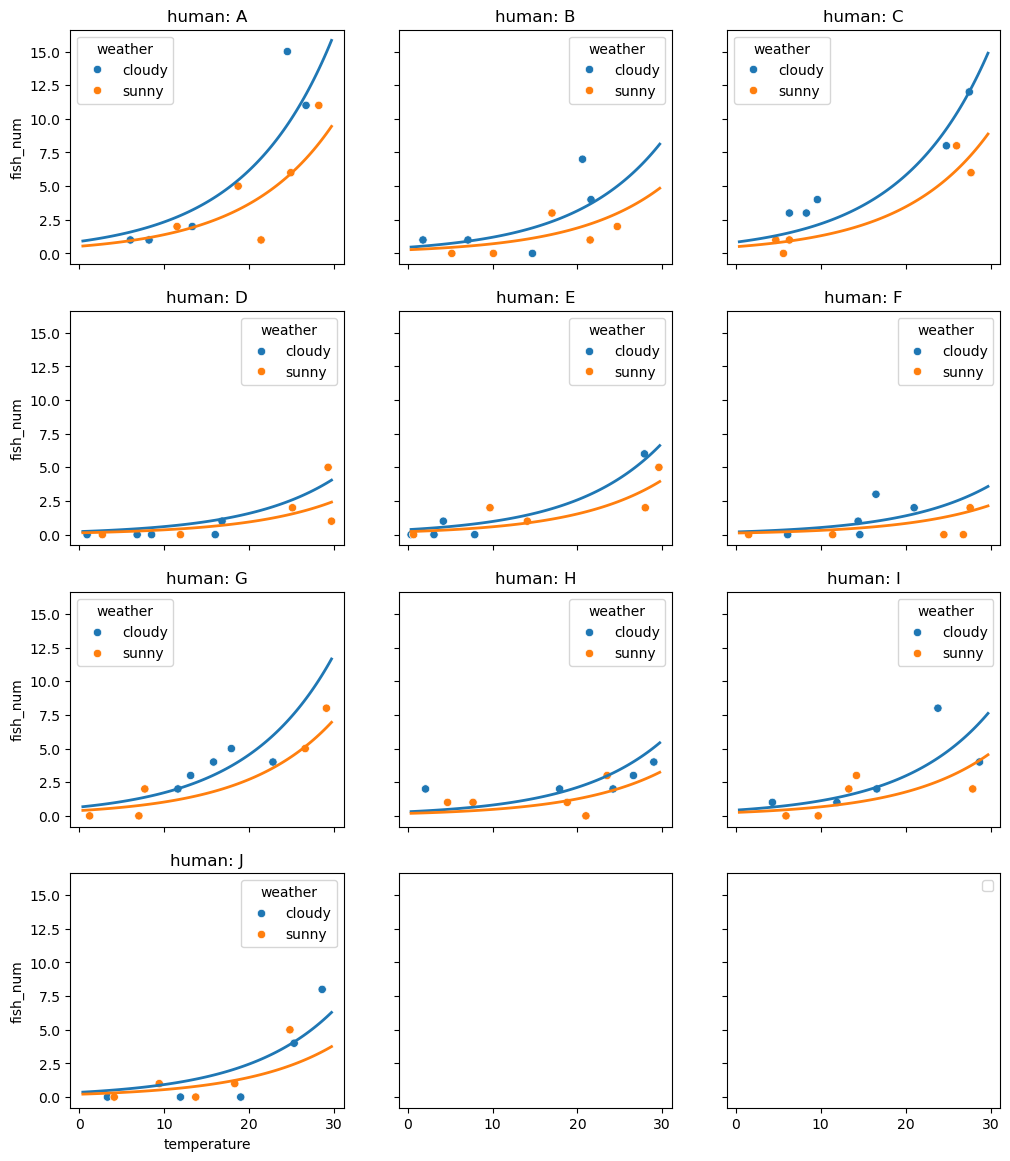

In [349]:
temp_values = temp_test[:100]
cmap = plt.get_cmap("tab10")

w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1 
w2_mean = summary['mean'].w2

hdis = az.hdi(prediction, hdi_prob=0.95)["mu"].values

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 14), sharex=True, sharey=True)
axes = axes.reshape(-1)

for i, h in enumerate(fish_nums.human.unique()):
    
    r_h_mean = summary['mean'][f'r[{i}]']
    
    # 各天気の回帰曲線
    sunny_mean = np.exp(w0_mean + w1_mean + w2_mean*temp_values + r_h_mean)
    cloudy_mean = np.exp(w0_mean + w2_mean*temp_values + r_h_mean)

    # 各天気の95% HDI
    hdi_human = hdis[i*200:i*200+200]
    hdi_sunny = hdi_human[:len(hdi_human)//2]
    hdi_cloudy = hdi_human[len(hdi_human)//2:]
    
    fish_num = fish_nums[fish_nums.human == h]
    sns.scatterplot(x='temperature', y='fish_num', data=fish_num, hue="weather", ax=axes[i])    # 観測値の散布図
    
    axes[i].set_title(f"human: {h}")

    # 回帰曲線のプロット
    axes[i].plot(temp_values, cloudy_mean, lw=2, c=cmap(0), label='cloudy regression line')
    axes[i].plot(temp_values, sunny_mean, lw=2, c=cmap(1), label='sunny regression line')

    # 95% HDIのプロット
    """
    axes[i].fill_between(temp_values, y1=hdi_cloudy[:,0], y2=hdi_cloudy[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy")
    axes[i].fill_between(temp_values, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny")
    """
plt.legend()
plt.show()

このように釣り人の能力を考慮することでより正確な固定効果を得られる。

### pystanでの実装

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
fish_nums = pd.read_csv('../data/3-2-fish-num.csv')

In [3]:
fish_nums.sort_values(["human", "weather", "temperature"], inplace=True)
fish_nums

fish_num weather  temperature human
0          1  cloudy          6.0     A
10         1  cloudy          8.2     A
30         2  cloudy         13.3     A
40        15  cloudy         24.5     A
20        11  cloudy         26.7     A
..       ...     ...          ...   ...
59         0   sunny          4.1     J
79         1   sunny          9.4     J
99         0   sunny         13.7     J
89         1   sunny         18.3     J
69         5   sunny         24.8     J

[100 rows x 4 columns]

In [21]:
y = fish_nums['fish_num'].values
temp = fish_nums['temperature'].values
weather = (fish_nums.weather=="sunny").values.astype(int)
X = np.vstack([np.ones(len(y)), weather, temp]).T

le = LabelEncoder()
human_id = le.fit_transform(fish_nums["human"].values)+1

In [22]:
temp_pred = np.tile(np.linspace(temp.min(), temp.max(), 50), 20)
weather_pred = np.tile(np.array([0] * 50 + [1] * 50), 10)
X_pred = np.vstack([np.ones(len(temp_pred)), weather_pred, temp_pred]).T

human_id_pred = le.fit_transform(np.tile(np.unique(fish_nums["human"]), (100, 1)).T.flatten()) + 1

In [23]:
stan_data = {
    "N": len(y),
    "K": X.shape[1],
    "N_human": len(np.unique(human_id)),
    "y": y,
    "X": X,
    "human_id": human_id,
    "N_pred": len(X_pred),
    "X_pred": X_pred,
    "human_id_pred": human_id_pred
}

In [24]:
with open('../stan/3-1-2-glmm-random-intercept.stan') as f:
    stan_code = f.read()

In [25]:
sm = stan.build(stan_code, data=stan_data, random_seed=1)

Building...

In file included from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Core:215,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/Dense:1,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/prim/fun/Eigen.hpp:22,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:4,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /usr/local/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /root/.cache/httpstan/4.12.0/models/zwvkymqk/model_zwvkymqk.cpp:2:
/usr/local/lib/python3.11/site-packages/httpstan/include/Eigen/src/Core/arch/NEON/PacketMath.h: In function ‘Packet Eigen::internal::pload(const typename unpacket_traits<T>::type*) [with Packet = eigen_packet_wrapper<int, 2>; typename unpacket_traits<T>::type = signed char]’:
/usr/local/lib/python3.11/


Building: 20.9s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [26]:
fit = sm.sample(num_chains=3, num_samples=6000, num_warmup=1000, num_thin=2)

Sampling:   0%
Sampling:  33% (7000/21000)
Sampling:  67% (14000/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 0.000105 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000105 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_fg33_lry/model_zwvkymqk.stan', line 28, column 8 to column 31)
  If this warning occurs sporadically, such as for highly const

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0] -0.869  0.303  -1.422   -0.275      0.005    0.004    3450.0   
beta[1] -0.518  0.133  -0.771   -0.270      0.001    0.001    8665.0   
beta[2]  0.097  0.009   0.080    0.114      0.000    0.000    7670.0   
sigma_r  0.641  0.218   0.308    1.031      0.003    0.002    5465.0   
r[0]     0.752  0.260   0.267    1.248      0.005    0.003    3062.0   
r[1]     0.085  0.296  -0.460    0.649      0.005    0.003    4043.0   
r[2]     0.686  0.264   0.168    1.164      0.005    0.003    3322.0   
r[3]    -0.617  0.337  -1.247    0.021      0.005    0.004    4418.0   
r[4]    -0.128  0.299  -0.687    0.441      0.005    0.003    3714.0   
r[5]    -0.740  0.343  -1.411   -0.117      0.005    0.004    4908.0   
r[6]     0.442  0.275  -0.072    0.960      0.005    0.003    3701.0   
r[7]    -0.321  0.293  -0.877    0.226      0.005    0.003    4049.0   
r[8]     0.021  0.281  -0.518    0.537      0.005    0.003    3514.0   
r[9]    -0.171  0.294  -0.703    0.400      0.005    0.003    3840.0   

         ess_tail  r_hat  
beta[0]    4576.0    1.0  
beta[1]    7437.0    1.0  
beta[2]    7632.0    1.0  
sigma_r    6153.0    1.0  
r[0]       3538.0    1.0  
r[1]       5051.0    1.0  
r[2]       3985.0    1.0  
r[3]       4903.0    1.0  
r[4]       4806.0    1.0  
r[5]       5725.0    1.0  
r[6]       4676.0    1.0  
r[7]       4815.0    1.0  
r[8]       4479.0    1.0  
r[9]       4911.0    1.0

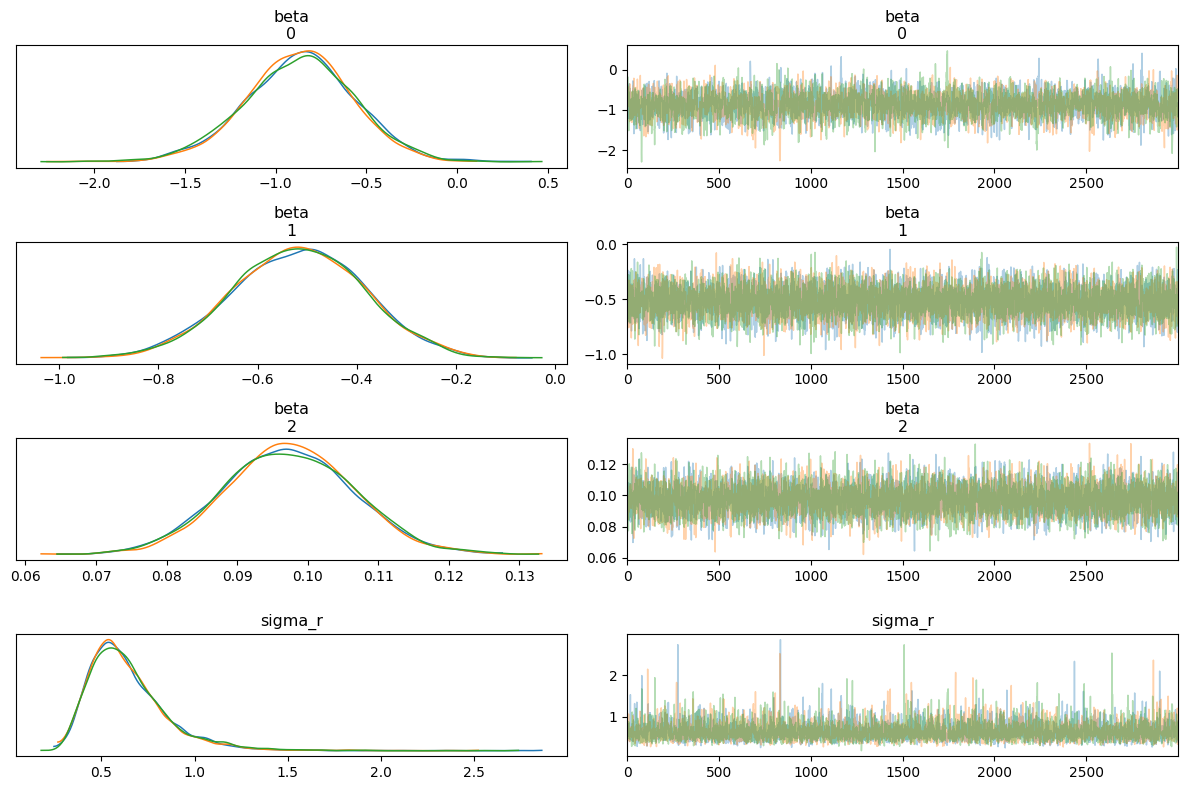

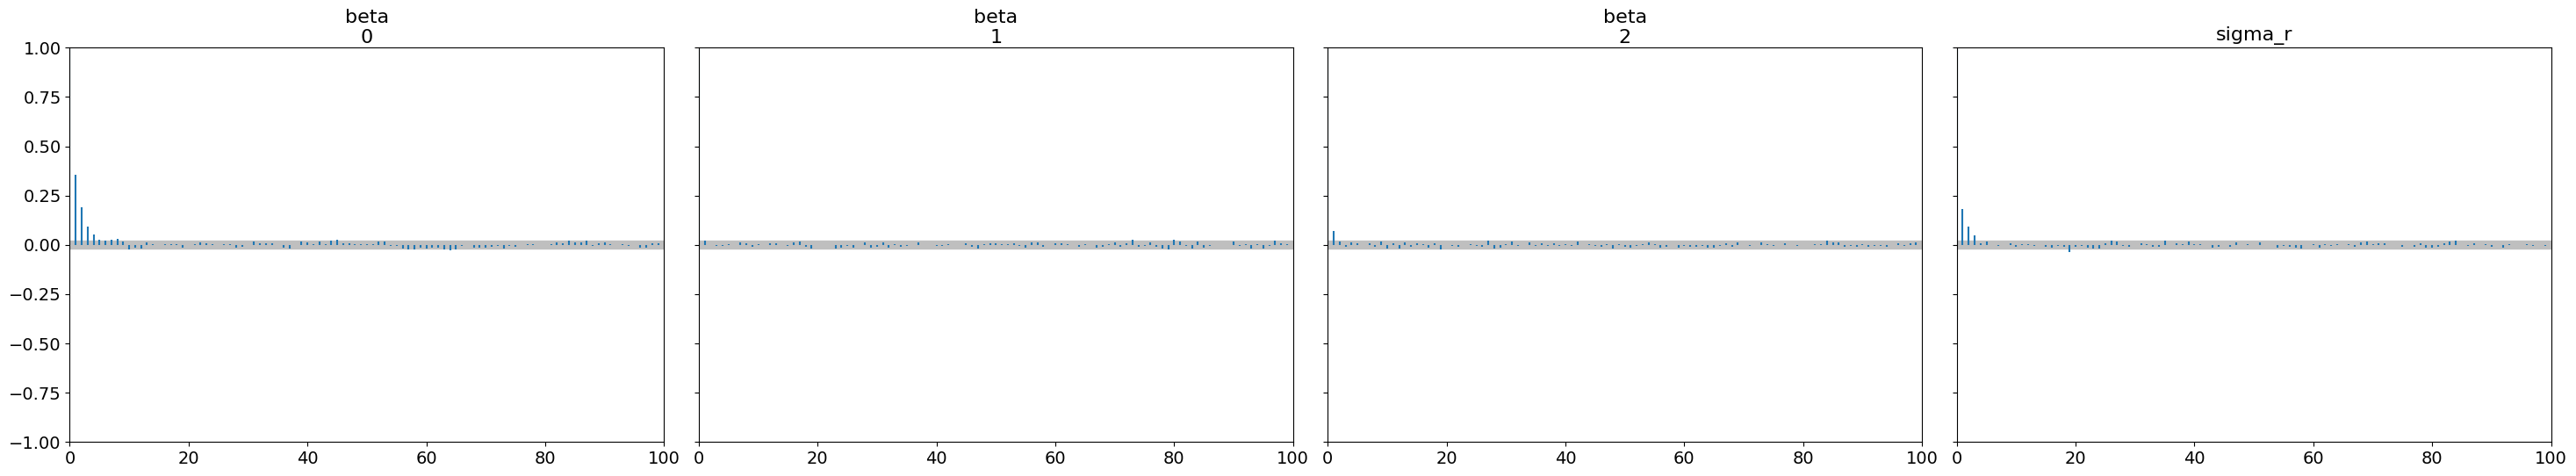

In [27]:
summary = az.summary(fit, var_names=["beta", "sigma_r", "r"])
display(summary)
az.plot_trace(fit, var_names=["beta", "sigma_r"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["beta", "sigma_r"], combined=True)
plt.tight_layout()

In [ ]:
temp_pred = np.tile(np.linspace(temp.min(), temp.max(), 50), 20)
weather_pred = np.tile(np.array([0] * 50 + [1] * 50), 10)
X_pred = np.vstack([np.ones(len(temp_pred)), weather_pred, temp_pred]).T

human_id_pred = le.fit_transform(np.tile(np.unique(fish_nums["human"]), (100, 1)).T.flatten()) + 1

In [37]:
np.unique(human_id_pred)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

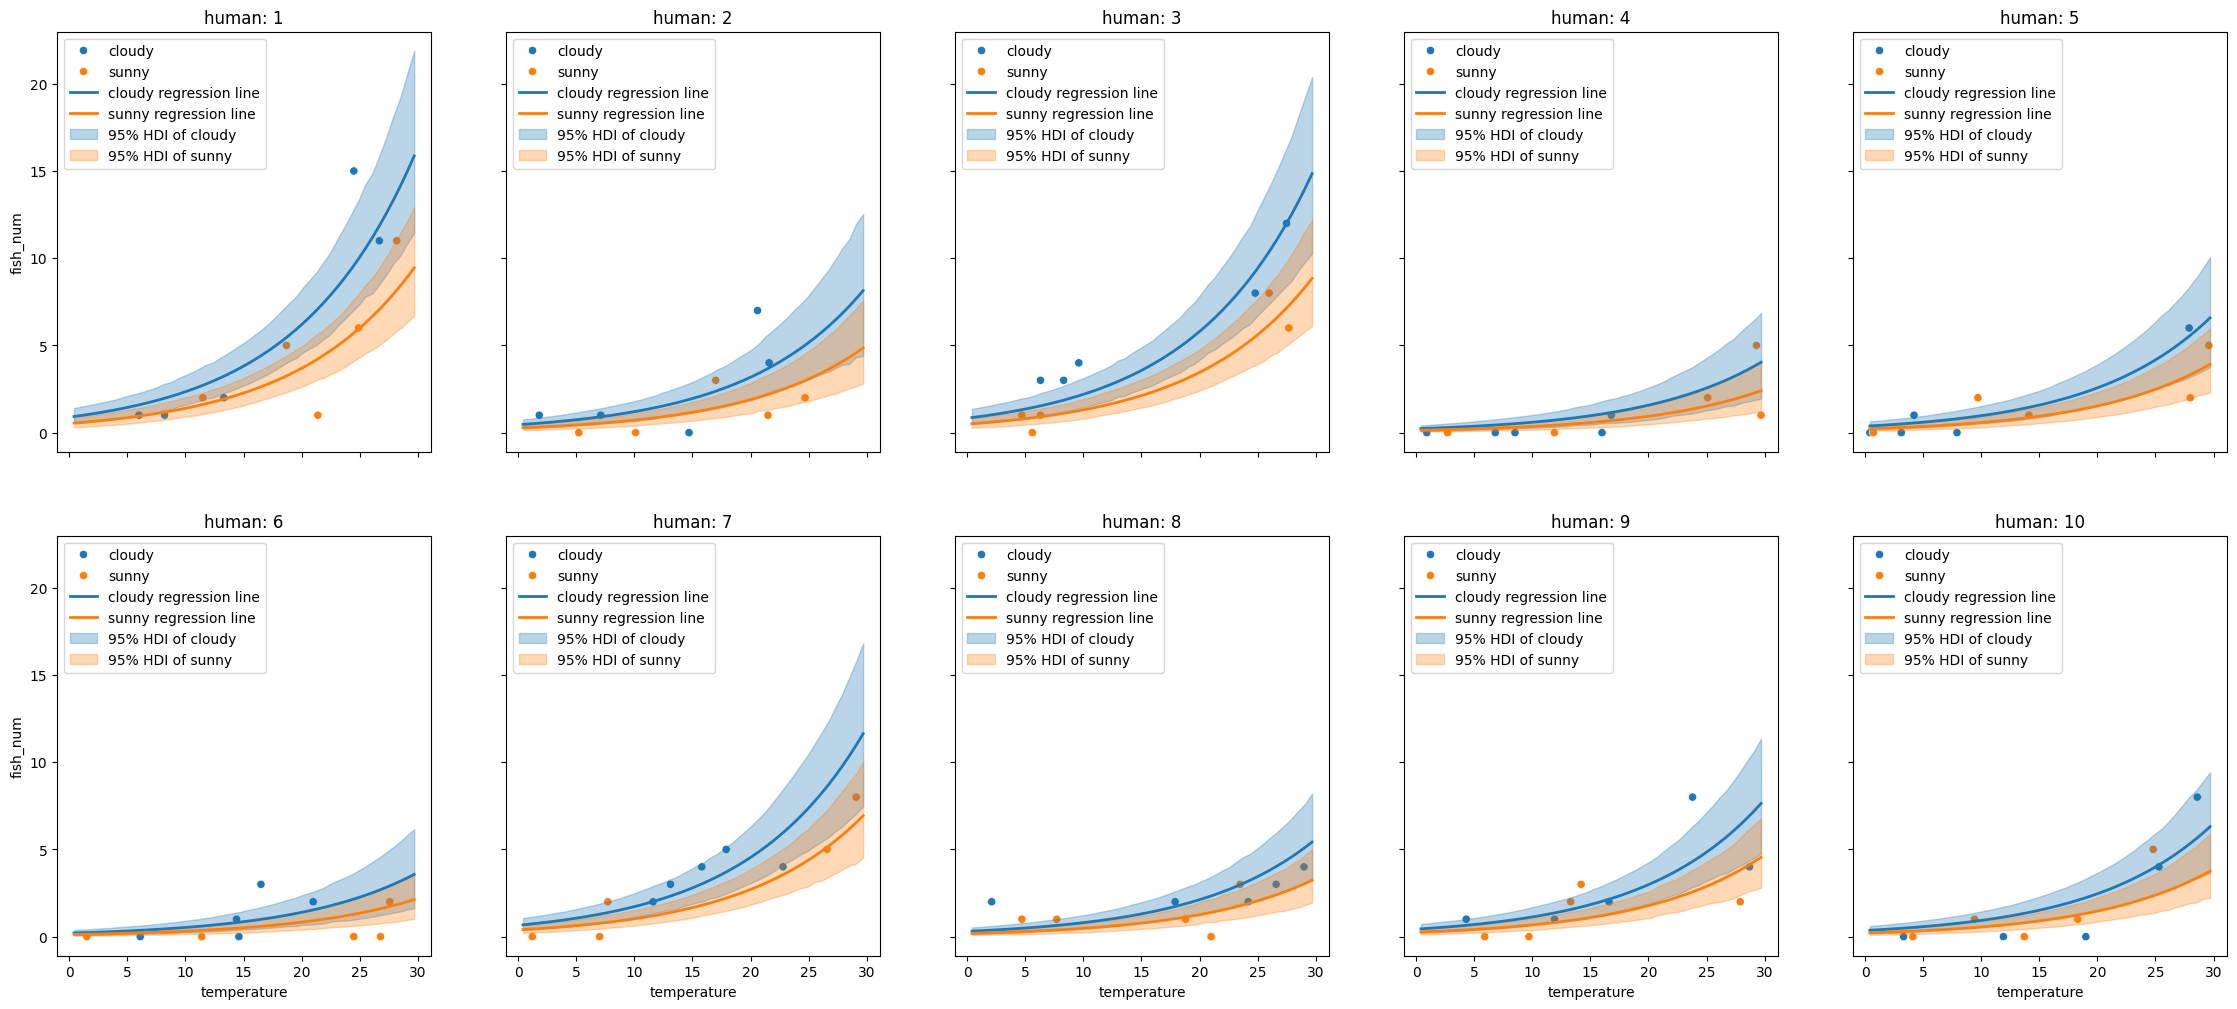

In [45]:
cmap = plt.get_cmap("tab10")

sunny_idx = X_pred[:,1] == 1
cloudy_idx = X_pred[:,1] == 0

beta_mean = az.summary(fit, var_names=["beta"])["mean"].values
means = np.dot(X_pred, beta_mean)

hdis = az.hdi(fit, hdi_prob=0.95)["lambda_pred"].values

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(28, 12), sharex=True, sharey=True)
axes = axes.reshape(-1)

for i, h in enumerate(np.unique(human_id_pred)):
    human_idx = human_id_pred == h
    human_r_mean = summary['mean'][f'r[{i}]']
    sunny_mean = means[sunny_idx & human_idx]
    cloudy_mean = means[cloudy_idx & human_idx]
    temp_values = temp_pred[sunny_idx & human_idx]
    
    # 各天気の回帰曲線
    sunny_reg = np.exp(sunny_mean + human_r_mean)
    cloudy_reg = np.exp(cloudy_mean + human_r_mean)

    # 各天気の95% HDI
    hdi_sunny = hdis[sunny_idx & human_idx]
    hdi_cloudy = hdis[cloudy_idx & human_idx]
    
    fish_num = fish_nums[human_id == h]
    sns.scatterplot(x='temperature', y='fish_num', data=fish_num, hue="weather", ax=axes[i])    # 観測値の散布図
    
    axes[i].set_title(f"human: {h}")

    # 回帰曲線のプロット
    axes[i].plot(temp_values, cloudy_reg, lw=2, c=cmap(0), label='cloudy regression line')
    axes[i].plot(temp_values, sunny_reg, lw=2, c=cmap(1), label='sunny regression line')

    # 95% HDIのプロット
    axes[i].fill_between(temp_values, y1=hdi_cloudy[:,0], y2=hdi_cloudy[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy")
    axes[i].fill_between(temp_values, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny")
    
    axes[i].legend(loc='upper left')

plt.show()

## ランダム係数モデル
ランダム切片モデルではランダム効果によって固定効果の値は変わらなかったが、ランダム係数モデルでは、ランダム効果によって固定効果の強さが変化する。

ここでは、釣り人の能力によって気温が釣果に与える影響が変わるとするモデル化をする。

### 交互作用によるモデル化(pymc)
釣り人の能力と気温の関係をモデル化するのであれば、交互作用によってモデル化することも可能になる。

In [37]:
fish_num = pd.read_csv('../data/3-3-fish-num.csv')

In [38]:
fish_num = fish_num.sort_values("human")

In [40]:
y = fish_num['fish_num'].values
temp = fish_num['temperature'].values
human = pd.get_dummies(fish_num['human'], drop_first=True).values.astype(int)
interaction = human * temp.reshape(-1,1)

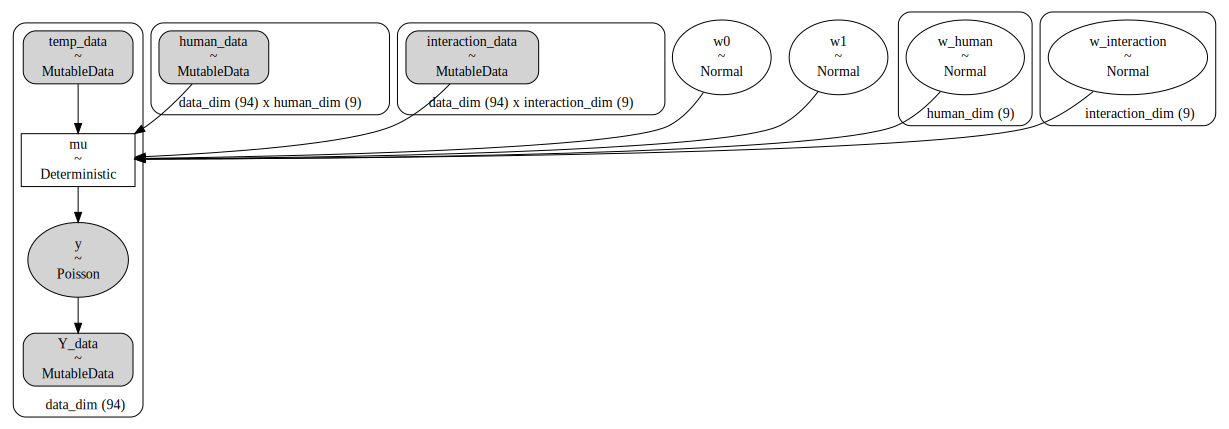

In [44]:
interaction_model = pm.Model()
with interaction_model:
    interaction_model.add_coord("data_dim", values=range(len(fish_num)), mutable=True)
    interaction_model.add_coord("human_dim", values=range(human.shape[1]), mutable=True)
    interaction_model.add_coord("interaction_dim", values=range(human.shape[1]), mutable=True)
    # X, Yの観測値をMutableDataとして定義
    temp_data = pm.MutableData('temp_data', temp, dims='data_dim')
    human_data = pm.MutableData('human_data', human, dims=('data_dim', "human_dim"))
    interaction_data = pm.MutableData('interaction_data', interaction, dims=('data_dim', "interaction_dim"))
    Y_data = pm.MutableData('Y_data', y, dims='data_dim')

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    w_human = pm.Normal("w_human", mu=0, sigma=20, dims='human_dim')
    w_interaction = pm.Normal("w_interaction", mu=0, sigma=20, dims='interaction_dim')
    """
    w0 = pm.Flat("w0")
    w1 = pm.Flat("w1")
    ws = pm.Flat("ws", shape=(9,))
    """
    # 期待値lambdaの計算
    # pm.math.expによって線形予測子を非線形変換
    mu = pm.Deterministic("mu", pm.math.exp(w0 + w1 * temp_data + pm.math.dot(human_data, w_human) + pm.math.dot(interaction_data, w_interaction)), dims='data_dim')

    # 観測値が従う確率分布の定義
    y_ = pm.Poisson('y', mu=mu, observed=Y_data, dims='data_dim')
    
g = pm.model_to_graphviz(interaction_model)
display(g)

In [45]:
with interaction_model:
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=5000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, w_human, w_interaction]


Sampling 3 chains for 2_000 tune and 5_000 draw iterations (6_000 + 15_000 draws total) took 66 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [46]:
summary = az.summary(trace)
display(summary)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w0          -2.314  1.066  -4.348   -0.330      0.024    0.017    2041.0   
w1           0.241  0.067   0.114    0.368      0.001    0.001    2042.0   
w_human[0]   1.658  1.204  -0.549    3.988      0.025    0.018    2371.0   
w_human[1]   2.215  1.238  -0.064    4.556      0.025    0.018    2497.0   
w_human[2]   2.286  1.484  -0.502    5.043      0.026    0.019    3143.0   
...            ...    ...     ...      ...        ...      ...       ...   
mu[89]       5.022  1.113   3.070    7.195      0.009    0.007   14941.0   
mu[90]       8.759  1.592   5.833   11.786      0.013    0.009   16045.0   
mu[91]      15.844  3.741   9.079   22.836      0.028    0.020   18266.0   
mu[92]       9.726  1.563   6.854   12.668      0.013    0.009   15356.0   
mu[93]       6.674  1.897   3.366   10.332      0.014    0.010   18292.0   

            ess_tail  r_hat  
w0            2974.0    1.0  
w1            3077.0    1.0  
w_human[0]    3873.0    1.0  
w_human[1]    4247.0    1.0  
w_human[2]    5274.0    1.0  
...              ...    ...  
mu[89]       11853.0    1.0  
mu[90]       11573.0    1.0  
mu[91]       11892.0    1.0  
mu[92]       11468.0    1.0  
mu[93]       12741.0    1.0  

[114 rows x 9 columns]

In [47]:
summary = az.summary(trace, var_names=["w0", "w1", "w_human", "w_interaction"])
display(summary)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w0               -2.314  1.066  -4.348   -0.330      0.024    0.017    2041.0   
w1                0.241  0.067   0.114    0.368      0.001    0.001    2042.0   
w_human[0]        1.658  1.204  -0.549    3.988      0.025    0.018    2371.0   
w_human[1]        2.215  1.238  -0.064    4.556      0.025    0.018    2497.0   
w_human[2]        2.286  1.484  -0.502    5.043      0.026    0.019    3143.0   
w_human[3]        2.679  1.233   0.332    4.962      0.025    0.018    2509.0   
w_human[4]        1.017  1.304  -1.353    3.523      0.025    0.018    2665.0   
w_human[5]        0.355  1.427  -2.224    3.161      0.025    0.018    3161.0   
w_human[6]        1.370  1.308  -0.996    3.934      0.025    0.018    2706.0   
w_human[7]       -0.493  1.613  -3.514    2.546      0.027    0.019    3447.0   
w_human[8]        6.063  1.273   3.767    8.532      0.025    0.018    2673.0   
w_interaction[0] -0.042  0.076  -0.190    0.097      0.002    0.001    2380.0   
w_interaction[1] -0.077  0.078  -0.224    0.068      0.002    0.001    2502.0   
w_interaction[2] -0.128  0.091  -0.305    0.039      0.002    0.001    3057.0   
w_interaction[3] -0.082  0.077  -0.221    0.067      0.002    0.001    2472.0   
w_interaction[4] -0.015  0.081  -0.167    0.136      0.002    0.001    2607.0   
w_interaction[5] -0.004  0.085  -0.174    0.148      0.002    0.001    2921.0   
w_interaction[6] -0.046  0.081  -0.203    0.102      0.002    0.001    2642.0   
w_interaction[7] -0.002  0.098  -0.185    0.183      0.002    0.001    3308.0   
w_interaction[8] -0.339  0.083  -0.491   -0.181      0.002    0.001    2797.0   

                  ess_tail  r_hat  
w0                  2974.0    1.0  
w1                  3077.0    1.0  
w_human[0]          3873.0    1.0  
w_human[1]          4247.0    1.0  
w_human[2]          5274.0    1.0  
w_human[3]          3963.0    1.0  
w_human[4]          4164.0    1.0  
w_human[5]          5224.0    1.0  
w_human[6]          4266.0    1.0  
w_human[7]          5447.0    1.0  
w_human[8]          4389.0    1.0  
w_interaction[0]    3948.0    1.0  
w_interaction[1]    4382.0    1.0  
w_interaction[2]    5126.0    1.0  
w_interaction[3]    3961.0    1.0  
w_interaction[4]    4079.0    1.0  
w_interaction[5]    4765.0    1.0  
w_interaction[6]    4440.0    1.0  
w_interaction[7]    5609.0    1.0  
w_interaction[8]    4630.0    1.0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w0    -0.396  0.243  -0.846    0.068      0.003    0.002    5288.0    7153.0   
w1     0.120  0.019   0.084    0.155      0.000    0.000    2946.0    5108.0   
ws[0]  0.063  0.013   0.039    0.086      0.000    0.000    2430.0    3877.0   
ws[1]  0.063  0.012   0.039    0.085      0.000    0.000    2406.0    4123.0   
ws[2]  0.015  0.013  -0.010    0.039      0.000    0.000    2530.0    4381.0   
ws[3]  0.084  0.012   0.063    0.106      0.000    0.000    2170.0    3568.0   
ws[4]  0.051  0.012   0.028    0.074      0.000    0.000    2461.0    4297.0   
ws[5]  0.030  0.012   0.006    0.052      0.000    0.000    2353.0    4050.0   
ws[6]  0.042  0.012   0.019    0.065      0.000    0.000    2433.0    4077.0   
ws[7] -0.024  0.015  -0.053    0.005      0.000    0.000    3385.0    6076.0   
ws[8]  0.040  0.015   0.011    0.067      0.000    0.000    2982.0    5031.0   

       r_hat  
w0       1.0  
w1       1.0  
ws[0]    1.0  
ws[1]    1.0  
ws[2]    1.0  
ws[3]    1.0  
ws[4]    1.0  
ws[5]    1.0  
ws[6]    1.0  
ws[7]    1.0  
ws[8]    1.0

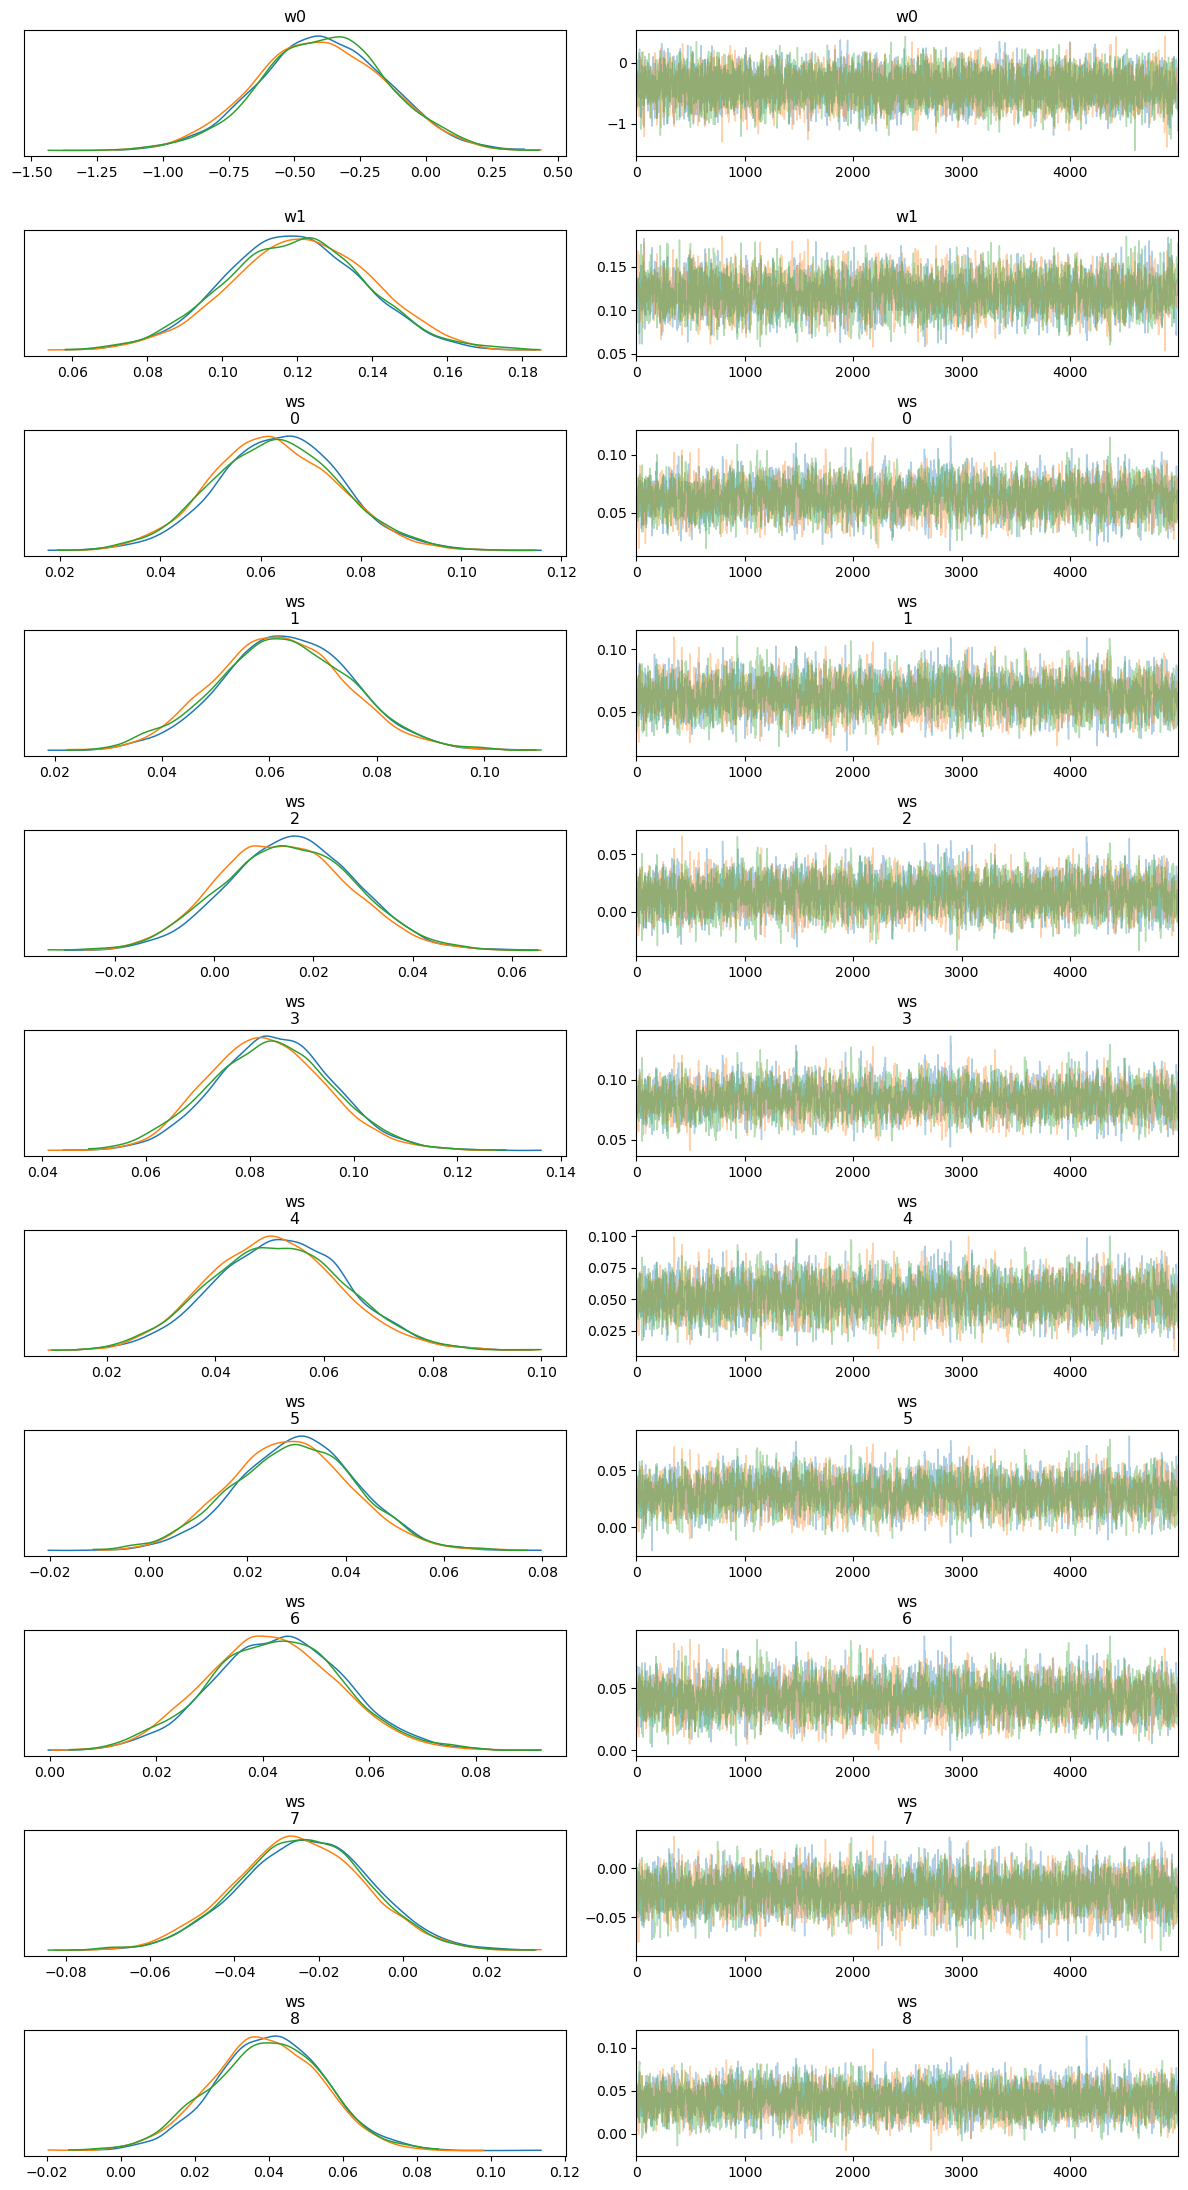

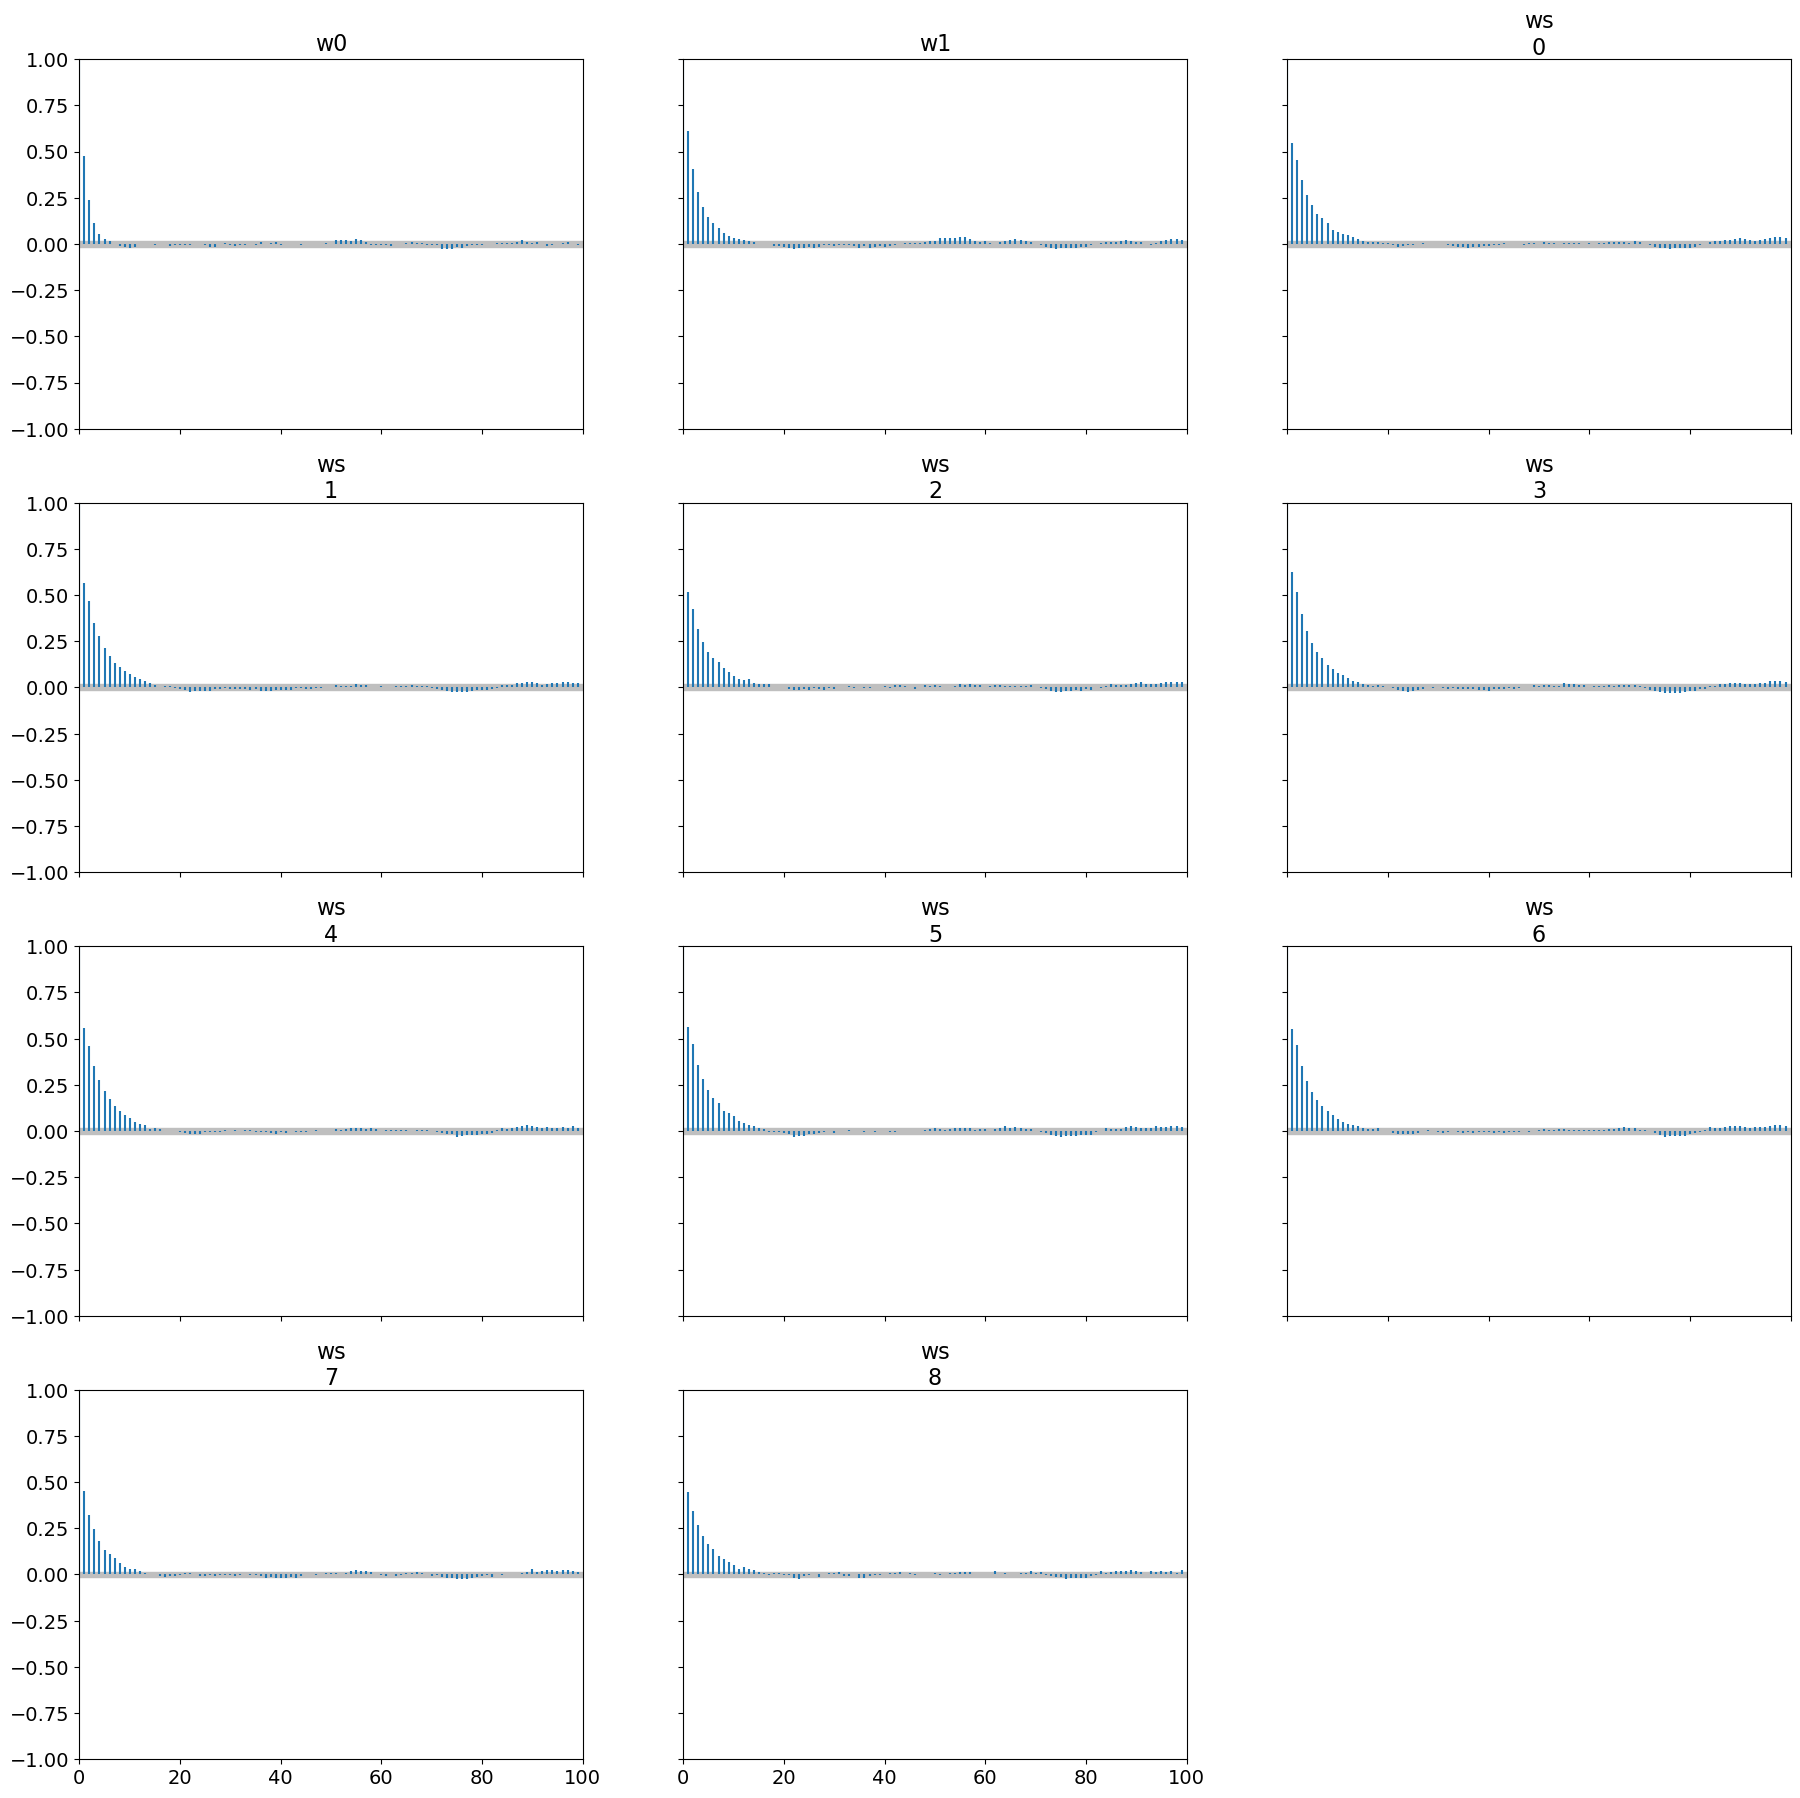

In [498]:
summary = az.summary(trace, var_names=["w0", "w1", "ws"])
display(summary)

az.plot_trace(trace, var_names=["w0", "w1", "ws"], compact=False)
plt.tight_layout()

az.plot_autocorr(trace, var_names=["w0", "w1", "ws"], combined=True)
plt.show()

In [48]:
posterior = trace.posterior

In [49]:
summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w0               -2.314  1.066  -4.348   -0.330      0.024    0.017    2041.0   
w1                0.241  0.067   0.114    0.368      0.001    0.001    2042.0   
w_human[0]        1.658  1.204  -0.549    3.988      0.025    0.018    2371.0   
w_human[1]        2.215  1.238  -0.064    4.556      0.025    0.018    2497.0   
w_human[2]        2.286  1.484  -0.502    5.043      0.026    0.019    3143.0   
w_human[3]        2.679  1.233   0.332    4.962      0.025    0.018    2509.0   
w_human[4]        1.017  1.304  -1.353    3.523      0.025    0.018    2665.0   
w_human[5]        0.355  1.427  -2.224    3.161      0.025    0.018    3161.0   
w_human[6]        1.370  1.308  -0.996    3.934      0.025    0.018    2706.0   
w_human[7]       -0.493  1.613  -3.514    2.546      0.027    0.019    3447.0   
w_human[8]        6.063  1.273   3.767    8.532      0.025    0.018    2673.0   
w_interaction[0] -0.042  0.076  -0.190    0.097      0.002    0.001    2380.0   
w_interaction[1] -0.077  0.078  -0.224    0.068      0.002    0.001    2502.0   
w_interaction[2] -0.128  0.091  -0.305    0.039      0.002    0.001    3057.0   
w_interaction[3] -0.082  0.077  -0.221    0.067      0.002    0.001    2472.0   
w_interaction[4] -0.015  0.081  -0.167    0.136      0.002    0.001    2607.0   
w_interaction[5] -0.004  0.085  -0.174    0.148      0.002    0.001    2921.0   
w_interaction[6] -0.046  0.081  -0.203    0.102      0.002    0.001    2642.0   
w_interaction[7] -0.002  0.098  -0.185    0.183      0.002    0.001    3308.0   
w_interaction[8] -0.339  0.083  -0.491   -0.181      0.002    0.001    2797.0   

                  ess_tail  r_hat  
w0                  2974.0    1.0  
w1                  3077.0    1.0  
w_human[0]          3873.0    1.0  
w_human[1]          4247.0    1.0  
w_human[2]          5274.0    1.0  
w_human[3]          3963.0    1.0  
w_human[4]          4164.0    1.0  
w_human[5]          5224.0    1.0  
w_human[6]          4266.0    1.0  
w_human[7]          5447.0    1.0  
w_human[8]          4389.0    1.0  
w_interaction[0]    3948.0    1.0  
w_interaction[1]    4382.0    1.0  
w_interaction[2]    5126.0    1.0  
w_interaction[3]    3961.0    1.0  
w_interaction[4]    4079.0    1.0  
w_interaction[5]    4765.0    1.0  
w_interaction[6]    4440.0    1.0  
w_interaction[7]    5609.0    1.0  
w_interaction[8]    4630.0    1.0

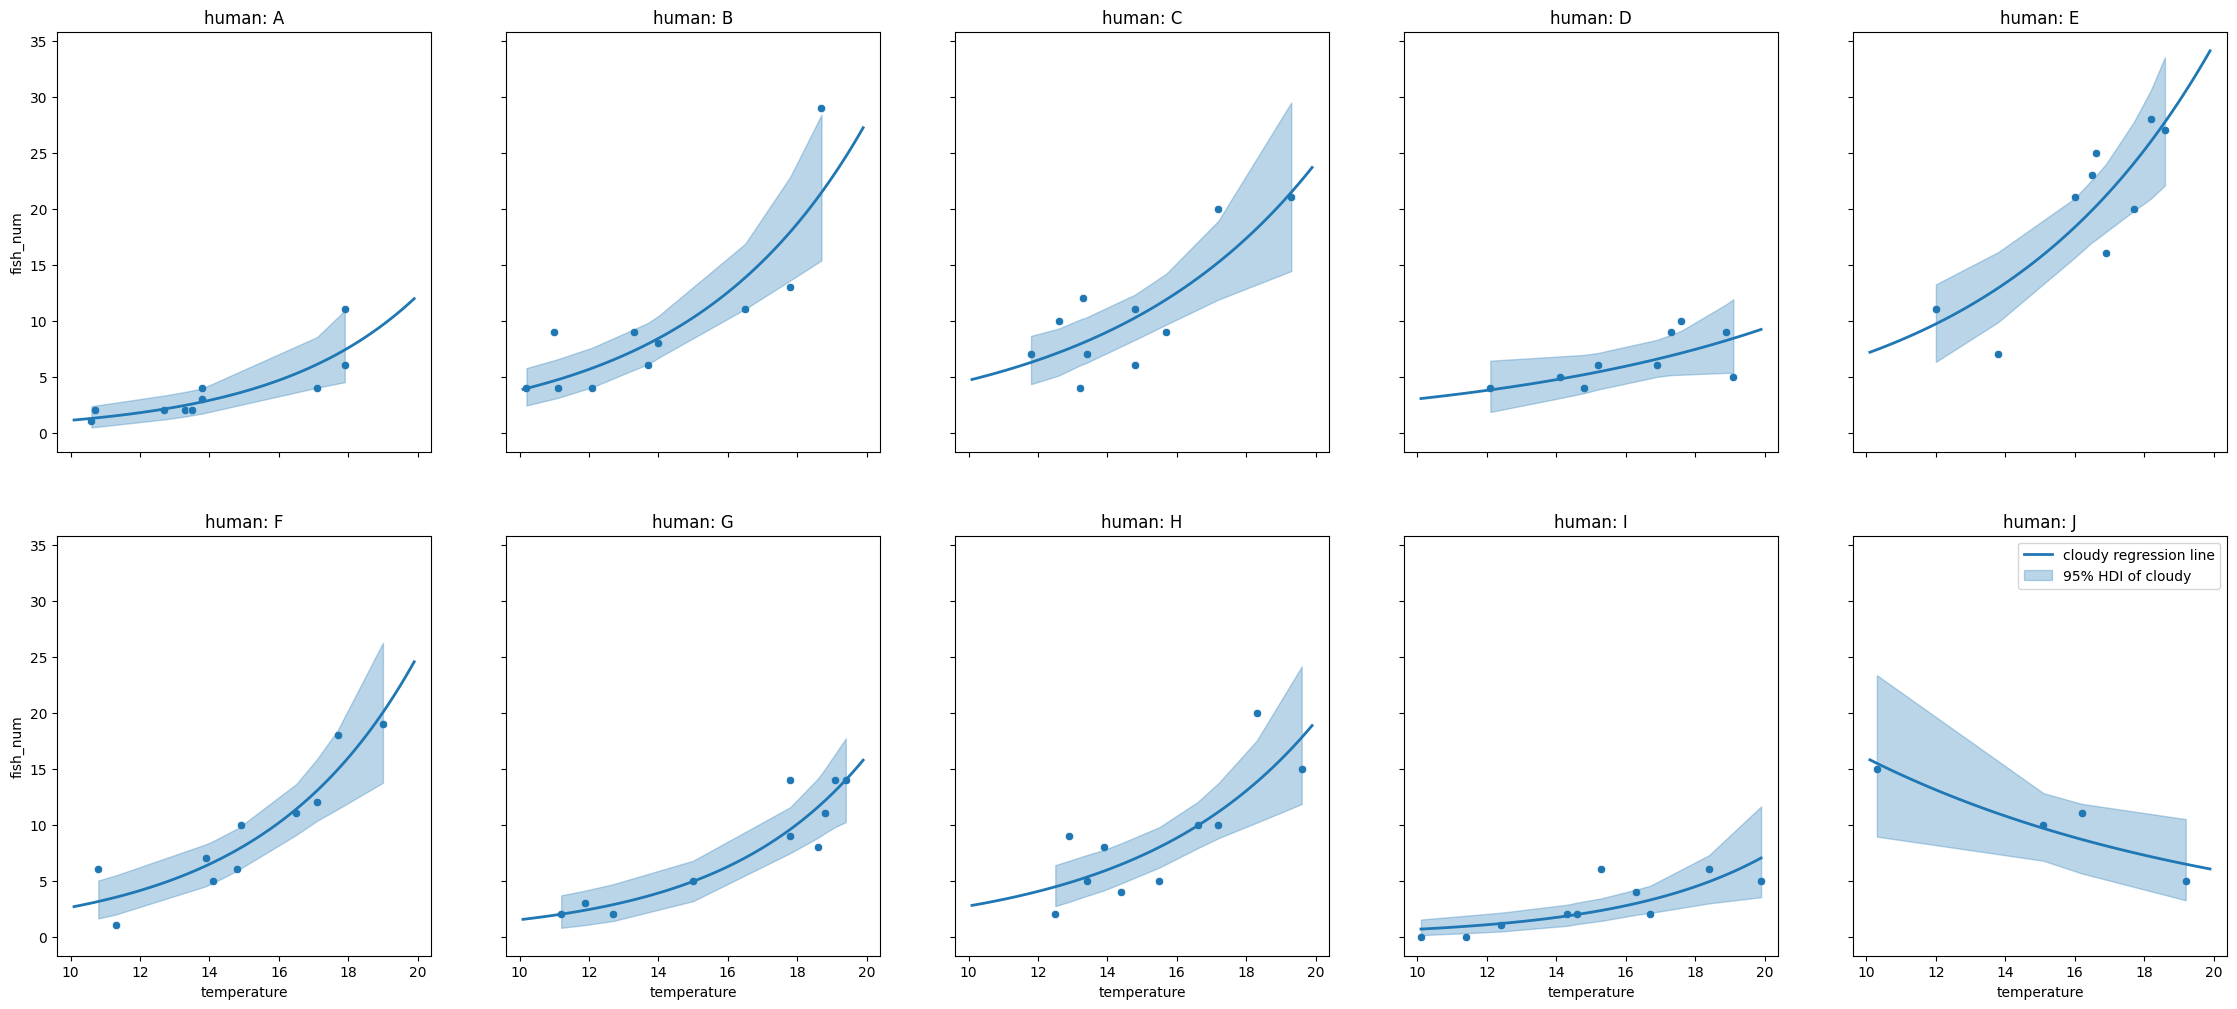

In [51]:
temp_values = np.linspace(temp.min(), temp.max(), 100)
cmap = plt.get_cmap("tab10")

w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1 

hdis = az.hdi(posterior, hdi_prob=0.95)["mu"].values

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(28, 12), sharex=True, sharey=True)
axes = axes.reshape(-1)

for i, h in enumerate(fish_num.human.unique()):
    human_idx = fish_num.human==h
    human_temp = temp[human_idx]
    temp_idx = np.argsort(human_temp)
    
    if i!=0:
        w_human = summary['mean'][f'w_human[{i-1}]']
        w_interaction = summary['mean'][f'w_interaction[{i-1}]']
    else:
        w_human = 0
        w_interaction = 0
    # 各天気の回帰曲線
    mean_reg = np.exp(w0_mean + (w1_mean+w_interaction)*temp_values + w_human)

    # 各天気の95% HDI
    hdi_human = hdis[human_idx][temp_idx]
    
    human_fish = fish_num[human_idx]
    sns.scatterplot(x='temperature', y='fish_num', data=human_fish, ax=axes[i])    # 観測値の散布図
    
    axes[i].set_title(f"human: {h}")

    # 回帰曲線のプロット
    axes[i].plot(temp_values, mean_reg, lw=2, c=cmap(0), label='cloudy regression line')

    # 95% HDIのプロット
    axes[i].fill_between(human_temp[temp_idx], y1=hdi_human[:,0], y2=hdi_human[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy")
   #axes[i].fill_between(temp_values, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny")
plt.legend()
plt.show()

Jの結果だけフィットしていないように見える(気温と釣果が負の関係になっている)。これはJさんのデ-タが少なく、たまたま寒い時に釣れたのかもしれない。そこで、ランダム効果による縮約を利用してデータを説明する。

### 交互作用によるモデル化(pystan)

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
fish_num = pd.read_csv('../data/3-3-fish-num.csv')

In [3]:
fish_num.sort_values(["human", "temperature"], inplace=True)
fish_num

fish_num  temperature human
9          1         10.6     A
54         2         10.7     A
0          2         12.7     A
63         2         13.3     A
72         2         13.5     A
..       ...          ...   ...
17         5         19.9     I
90        15         10.3     J
91        10         15.1     J
92        11         16.2     J
93         5         19.2     J

[94 rows x 3 columns]

In [11]:
y = fish_num['fish_num'].values
temp = fish_num['temperature'].values
human = pd.get_dummies(fish_num['human'], drop_first=True).values.astype(int)
interaction = human * temp.reshape(-1, 1)
X = np.hstack([np.ones((len(y), 1)), temp.reshape(-1, 1), human, interaction])

In [12]:
temp_pred = np.tile(np.linspace(temp.min(), temp.max(), 50), 10)
human_pred = pd.get_dummies(np.tile(fish_num.human.unique(), (50, 1)).T.flatten(), drop_first=True).values.astype(int)
X_pred = np.hstack([np.ones((len(temp_pred), 1)), temp_pred.reshape(-1, 1), human_pred, (human_pred * temp_pred.reshape(-1, 1))])

In [13]:
stan_data = {
    "N": len(y),
    "K": X.shape[1],
    "y": y,
    "X": X,
    "N_pred": len(X_pred),
    "X_pred": X_pred
}

In [14]:
with open('../stan/3-1-3-interaction.stan') as f:
    stan_code = f.read()

In [15]:
sm = stan.build(stan_code, data=stan_data, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [16]:
fit = sm.sample(num_chains=3, num_samples=6000, num_warmup=1000, num_thin=2)

Sampling:   0%
Sampling:   0% (1/21000)
Sampling:   0% (101/21000)
Sampling:   0% (102/21000)
Sampling:   2% (401/21000)
Sampling:   4% (801/21000)
Sampling:   6% (1300/21000)
Sampling:   9% (1800/21000)
Sampling:  34% (7200/21000)
Sampling:  65% (13700/21000)
Sampling:  95% (19900/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 0.000174 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.74 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
  Adjust your expectations accordingly!


In [17]:
summary = az.summary(fit, var_names=["beta"])
display(summary)
"""
az.plot_trace(fit, var_names=["beta"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["beta"], combined=True)
plt.show()
"""

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  -2.363  1.065  -4.472   -0.462      0.024    0.017    2028.0   
beta[1]   0.244  0.067   0.119    0.371      0.001    0.001    2027.0   
beta[2]   1.705  1.215  -0.490    4.017      0.025    0.018    2342.0   
beta[3]   2.266  1.233  -0.185    4.459      0.025    0.018    2390.0   
beta[4]   2.321  1.476  -0.456    5.065      0.027    0.019    3051.0   
beta[5]   2.732  1.228   0.459    5.079      0.025    0.018    2339.0   
beta[6]   1.058  1.291  -1.401    3.513      0.026    0.018    2564.0   
beta[7]   0.401  1.432  -2.289    3.127      0.027    0.019    2837.0   
beta[8]   1.403  1.308  -1.006    3.880      0.026    0.019    2471.0   
beta[9]  -0.454  1.612  -3.504    2.636      0.029    0.020    3188.0   
beta[10]  6.117  1.266   3.703    8.499      0.025    0.018    2581.0   
beta[11] -0.045  0.077  -0.186    0.101      0.002    0.001    2322.0   
beta[12] -0.081  0.078  -0.220    0.074      0.002    0.001    2399.0   
beta[13] -0.131  0.091  -0.296    0.044      0.002    0.001    2952.0   
beta[14] -0.086  0.077  -0.231    0.057      0.002    0.001    2307.0   
beta[15] -0.018  0.080  -0.171    0.135      0.002    0.001    2523.0   
beta[16] -0.008  0.086  -0.180    0.145      0.002    0.001    2668.0   
beta[17] -0.049  0.081  -0.205    0.097      0.002    0.001    2374.0   
beta[18] -0.005  0.098  -0.195    0.178      0.002    0.001    3036.0   
beta[19] -0.343  0.082  -0.493   -0.182      0.002    0.001    2669.0   

          ess_tail  r_hat  
beta[0]     2862.0    1.0  
beta[1]     2722.0    1.0  
beta[2]     3282.0    1.0  
beta[3]     3302.0    1.0  
beta[4]     4689.0    1.0  
beta[5]     3671.0    1.0  
beta[6]     4245.0    1.0  
beta[7]     4341.0    1.0  
beta[8]     3768.0    1.0  
beta[9]     4646.0    1.0  
beta[10]    4003.0    1.0  
beta[11]    3087.0    1.0  
beta[12]    3547.0    1.0  
beta[13]    4563.0    1.0  
beta[14]    3613.0    1.0  
beta[15]    4397.0    1.0  
beta[16]    4058.0    1.0  
beta[17]    3810.0    1.0  
beta[18]    4808.0    1.0  
beta[19]    3726.0    1.0

'\naz.plot_trace(fit, var_names=["beta"], compact=False)\nplt.tight_layout()\n\naz.plot_autocorr(fit, var_names=["beta"], combined=True)\nplt.show()\n'

In [ ]:
temp_pred = np.tile(np.linspace(temp.min(), temp.max(), 50), 10)
human_pred = pd.get_dummies(np.tile(fish_num.human.unique(), (50, 1)).T.flatten(), drop_first=True).values.astype(int)
X_pred = np.hstack([np.ones((len(temp_pred), 1)), temp_pred.reshape(-1, 1), human_pred, (human_pred * temp_pred.reshape(-1, 1))])

In [26]:
human_categories = np.tile(fish_num.human.unique(), (50, 1)).T.flatten()

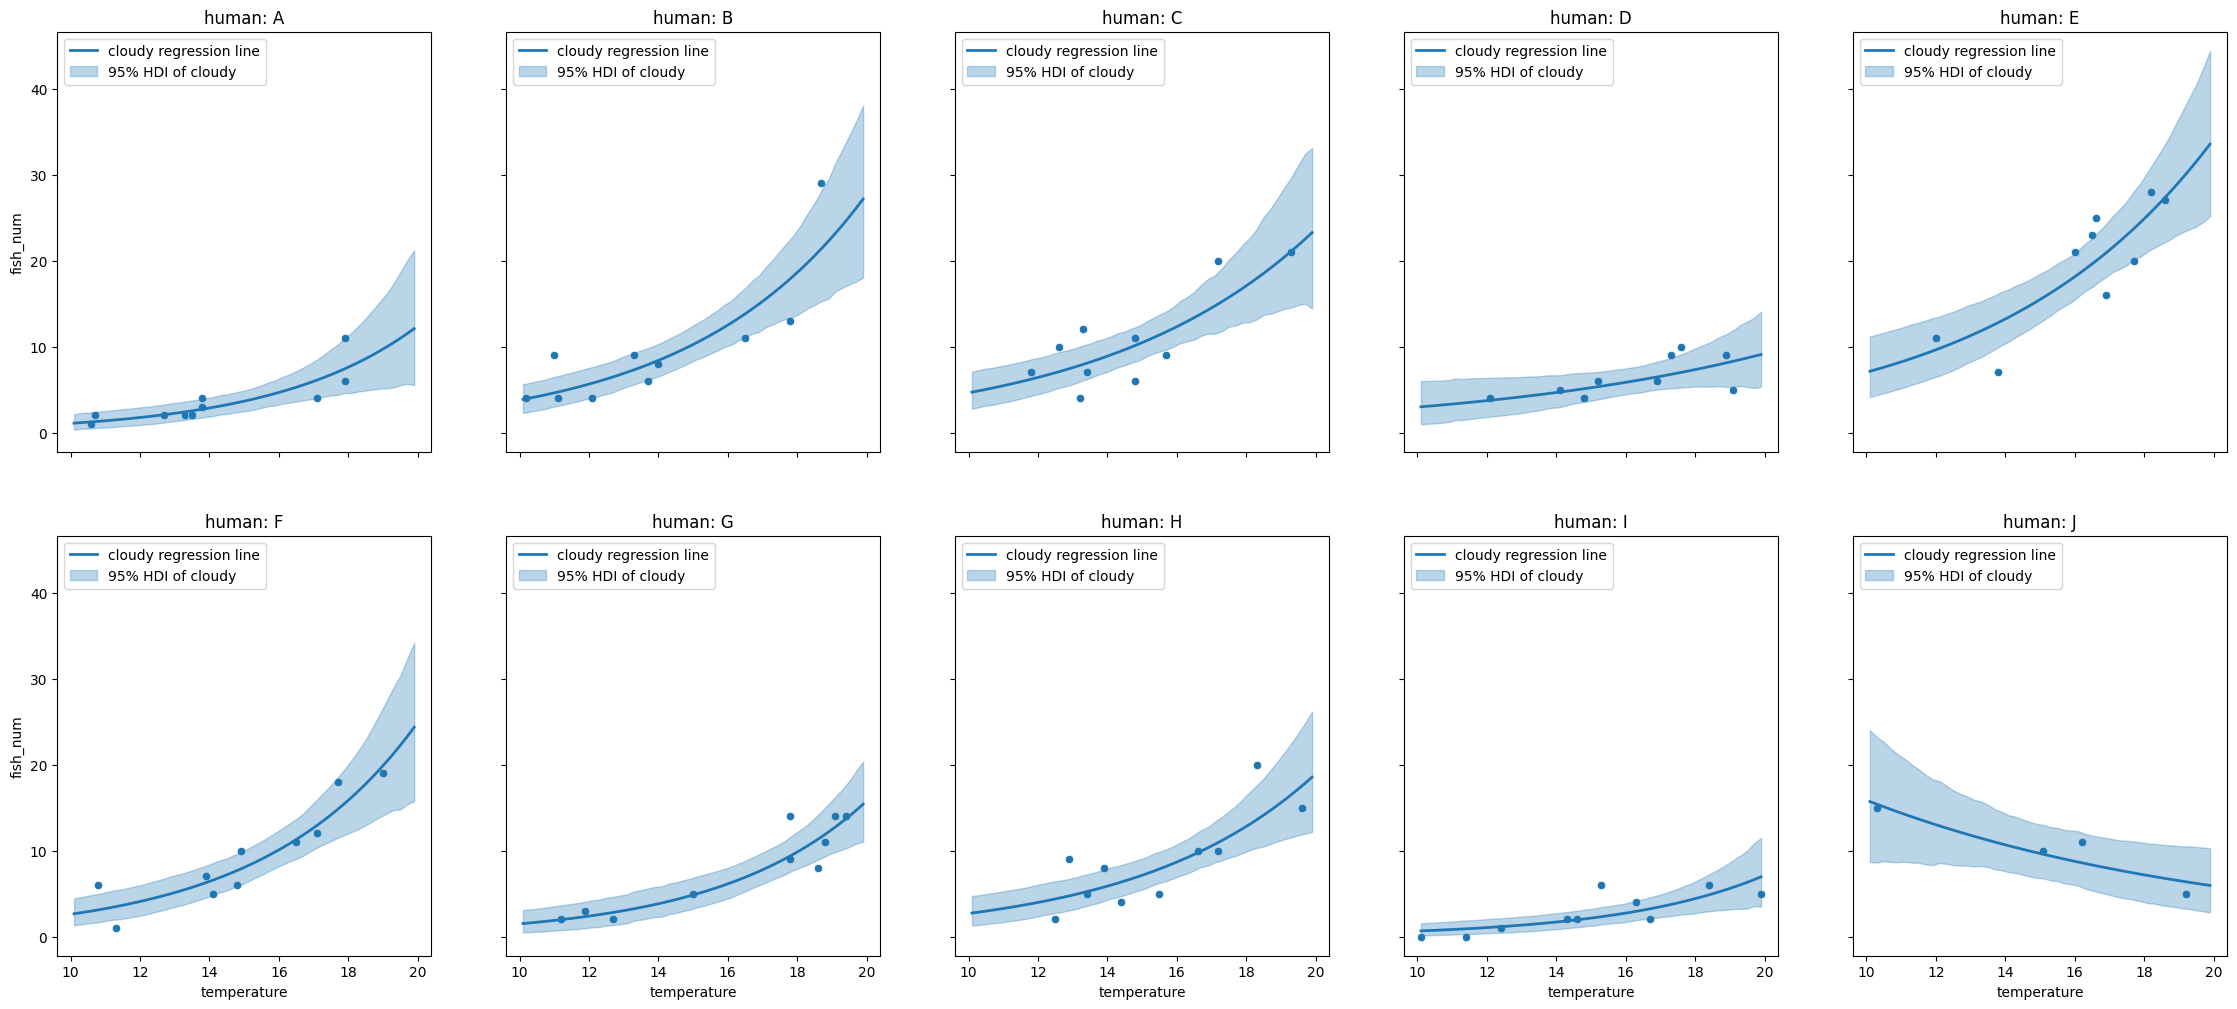

In [30]:
cmap = plt.get_cmap("tab10")

beta_mean = summary['mean'].values
means = np.exp(np.dot(X_pred, beta_mean))

hdis = az.hdi(fit, hdi_prob=0.95)["lambda_pred"].values

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(28, 12), sharex=True, sharey=True)
axes = axes.reshape(-1)

for i, h in enumerate(fish_num.human.unique()):
    human_idx = human_categories==h
    human_temp = temp_pred[human_idx]
    mean_reg = means[human_idx]

    # 各天気の95% HDI
    hdi_human = hdis[human_idx]
    
    human_fish = fish_num[fish_num.human == h]
    sns.scatterplot(x='temperature', y='fish_num', data=human_fish, ax=axes[i])    # 観測値の散布図
    
    axes[i].set_title(f"human: {h}")

    # 回帰曲線のプロット
    axes[i].plot(human_temp, mean_reg, lw=2, c=cmap(0), label='cloudy regression line')

    # 95% HDIのプロット
    axes[i].fill_between(human_temp, y1=hdi_human[:,0], y2=hdi_human[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy")
    #axes[i].fill_between(temp_values, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny")
    axes[i].legend(loc='upper left')

plt.show()

### 階層化によるモデル化(pymc)
ランダム効果を用いると、縮約という効果が起きる。縮約とは、グループ間で情報を共有することで他のグループの情報を借りて自分のグループについて説明する効果で、標準ベイズでは縮小とも言われている(標準ベイズ p158)。ランダム効果によるモデリングは次のようになる。
$$
\tau_k \sim Normal(0, \sigma_\tau^2) \\
r_k \sim Normal(0, \sigma_r^2) \\
\lambda_i = \exp(w_0 + (w_1+ \tau_k)x_{1i} + r_k) \\
y_i \sim Poisson(\lambda_i)
$$

In [473]:
y = fish_num['fish_num'].values
temp = fish_num['temperature'].values
human = pd.get_dummies(fish_num['human']).values.astype(int)

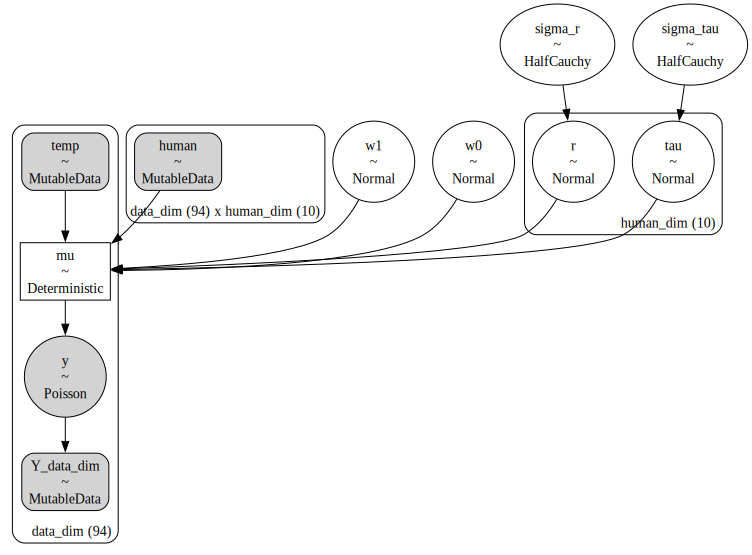

In [474]:
random_coef_model = pm.Model()
with random_coef_model:
    random_coef_model.add_coord("data_dim", values=range(len(fish_num)), mutable=True)
    random_coef_model.add_coord("human_dim", values=range(human.shape[1]), mutable=True)
    # X, Yの観測値をMutableDataとして定義
    temp_data = pm.MutableData('temp', temp, dims='data_dim')
    human_data = pm.MutableData('human', human, dims=('data_dim', "human_dim"))
    Y_data = pm.MutableData('Y_data_dim', y, dims='data_dim')

    # 確率変数w0, w1の定義(一次関数の傾きと切片)
    w0 = pm.Normal("w0", mu=0, sigma=20)
    w1 = pm.Normal("w1", mu=0, sigma=20)
    sigma_r = pm.HalfCauchy("sigma_r", beta=10)
    sigma_tau = pm.HalfCauchy("sigma_tau", beta=10)
    
    r = pm.Normal("r", mu=0, sigma=sigma_r, dims='human_dim')
    tau = pm.Normal("tau", mu=0, sigma=sigma_tau, dims='human_dim')

    # 期待値lambdaの計算
    # pm.math.expによって線形予測子を非線形変換
    mu = pm.Deterministic("mu", pm.math.exp(w0 + (w1 + pm.math.dot(human_data, tau)) * temp_data + pm.math.dot(human_data, r)), dims='data_dim')

    # 観測値が従う確率分布の定義
    y_ = pm.Poisson('y', mu=mu, observed=Y_data, dims='data_dim')
    
g = pm.model_to_graphviz(random_coef_model)
display(g)

In [475]:
with random_coef_model:
    trace = pm.sample(
        # 乱数系列の数(デフォルト2)
        chains=3,
        # 捨てるサンプル数(デフォルト1000)
        tune=2000,
        # 取得するサンプル数(デフォルト1000)
        draws=3000,
        random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w0, w1, sigma_r, sigma_tau, r, tau]


Sampling 3 chains for 2_000 tune and 3_000 draw iterations (6_000 + 9_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w0     -0.484  0.435  -1.299    0.353      0.008    0.006    3484.0    3143.0   
w1      0.162  0.024   0.118    0.206      0.000    0.000    4480.0    3960.0   
r[0]   -0.686  0.632  -2.047    0.410      0.011    0.009    4046.0    3090.0   
r[1]    0.075  0.521  -0.998    1.007      0.010    0.007    2923.0    3330.0   
r[2]    0.315  0.532  -0.742    1.354      0.008    0.007    4867.0    3705.0   
r[3]   -0.052  0.616  -1.141    1.257      0.010    0.008    4292.0    3657.0   
r[4]    0.650  0.544  -0.415    1.725      0.009    0.007    3941.0    3534.0   
r[5]   -0.178  0.576  -1.318    0.838      0.011    0.009    2838.0    3422.0   
r[6]   -0.491  0.633  -1.773    0.576      0.013    0.010    2901.0    3223.0   
r[7]   -0.128  0.564  -1.298    0.880      0.009    0.008    4493.0    4237.0   
r[8]   -0.939  0.659  -2.248    0.214      0.012    0.011    4160.0    2596.0   
r[9]    1.486  1.080  -0.144    3.494      0.036    0.026     842.0    3519.0   
tau[0]  0.008  0.038  -0.060    0.086      0.001    0.001    4720.0    3592.0   
tau[1]  0.021  0.031  -0.031    0.083      0.001    0.000    3265.0    3864.0   
tau[2]  0.006  0.031  -0.052    0.069      0.000    0.000    6812.0    4160.0   
tau[3] -0.018  0.035  -0.092    0.042      0.001    0.000    4948.0    3928.0   
tau[4]  0.008  0.030  -0.053    0.063      0.000    0.000    5115.0    4424.0   
tau[5]  0.025  0.034  -0.031    0.093      0.001    0.001    3291.0    4066.0   
tau[6]  0.020  0.035  -0.040    0.092      0.001    0.001    3039.0    3494.0   
tau[7]  0.013  0.032  -0.044    0.081      0.000    0.000    5052.0    3726.0   
tau[8] -0.002  0.038  -0.069    0.077      0.001    0.001    4017.0    2616.0   
tau[9] -0.082  0.066  -0.203    0.011      0.002    0.002     767.0    2991.0   

        r_hat  
w0        1.0  
w1        1.0  
r[0]      1.0  
r[1]      1.0  
r[2]      1.0  
r[3]      1.0  
r[4]      1.0  
r[5]      1.0  
r[6]      1.0  
r[7]      1.0  
r[8]      1.0  
r[9]      1.0  
tau[0]    1.0  
tau[1]    1.0  
tau[2]    1.0  
tau[3]    1.0  
tau[4]    1.0  
tau[5]    1.0  
tau[6]    1.0  
tau[7]    1.0  
tau[8]    1.0  
tau[9]    1.0

/Users/hakiitakeru/opt/miniforge3/envs/bayes/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


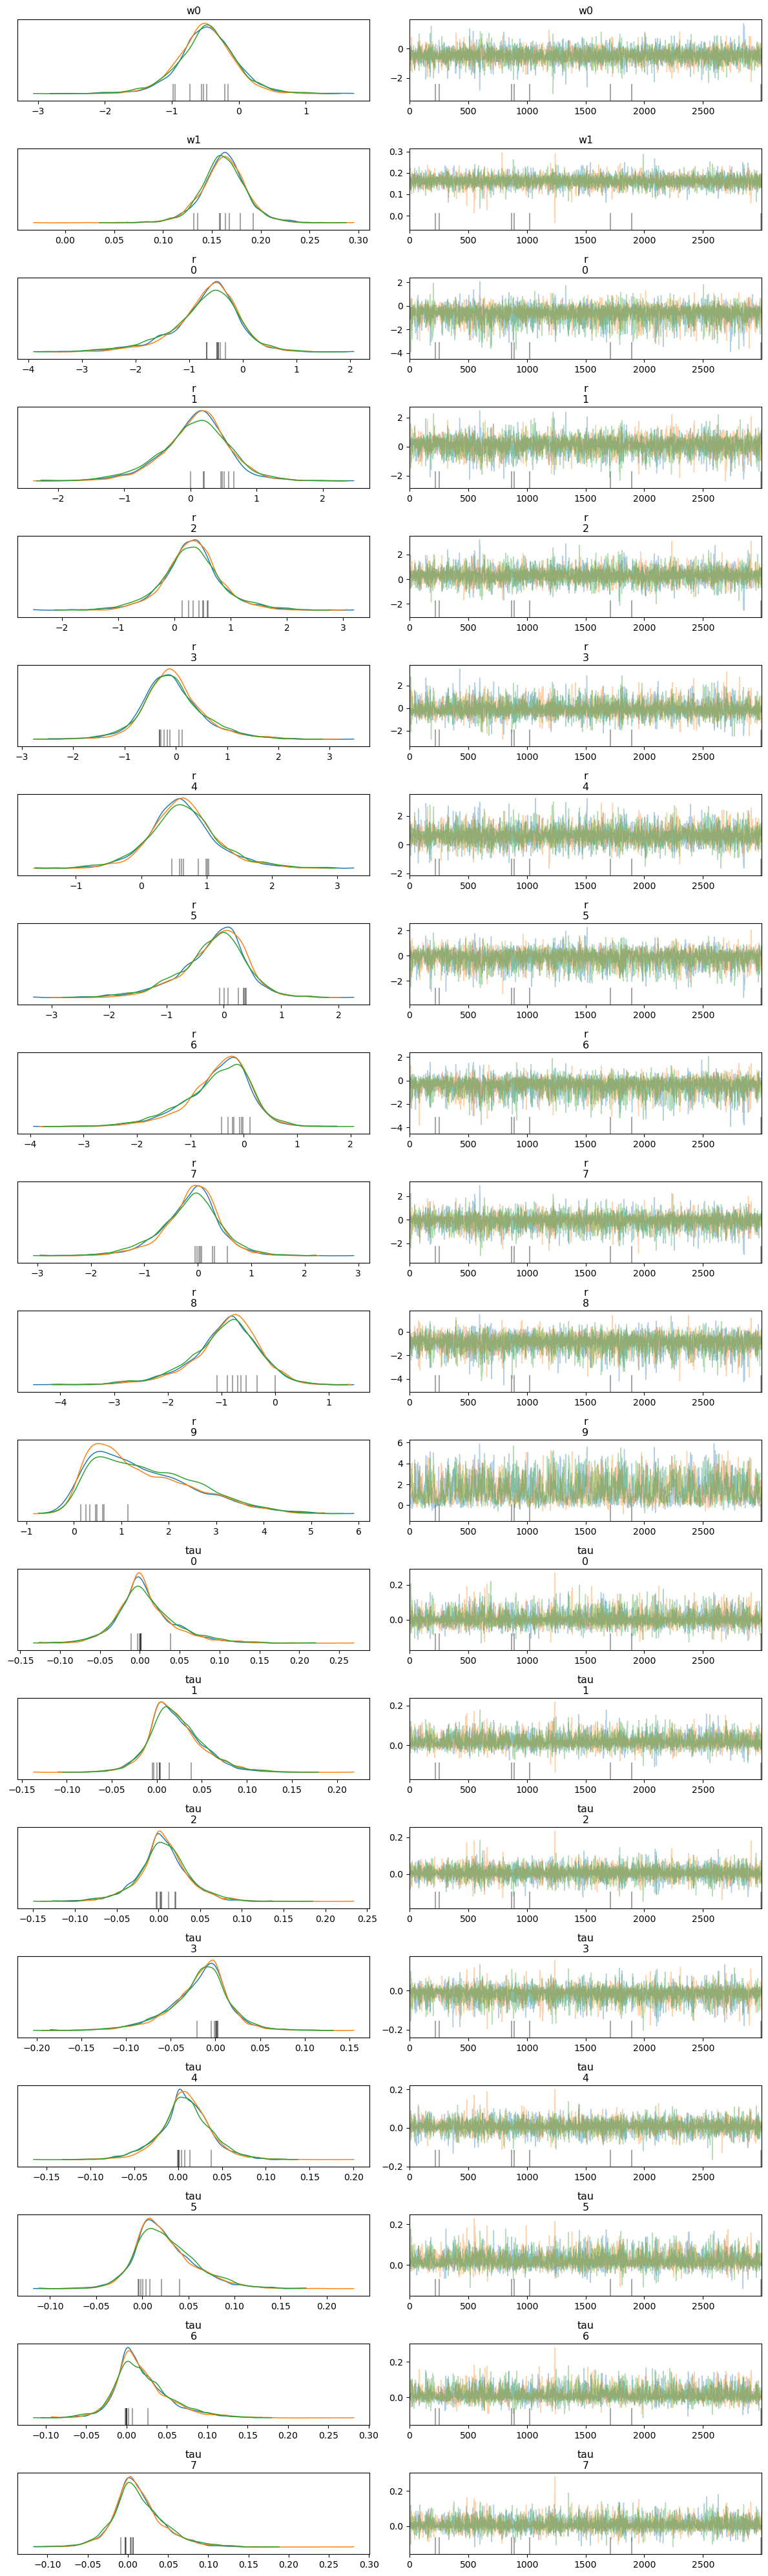

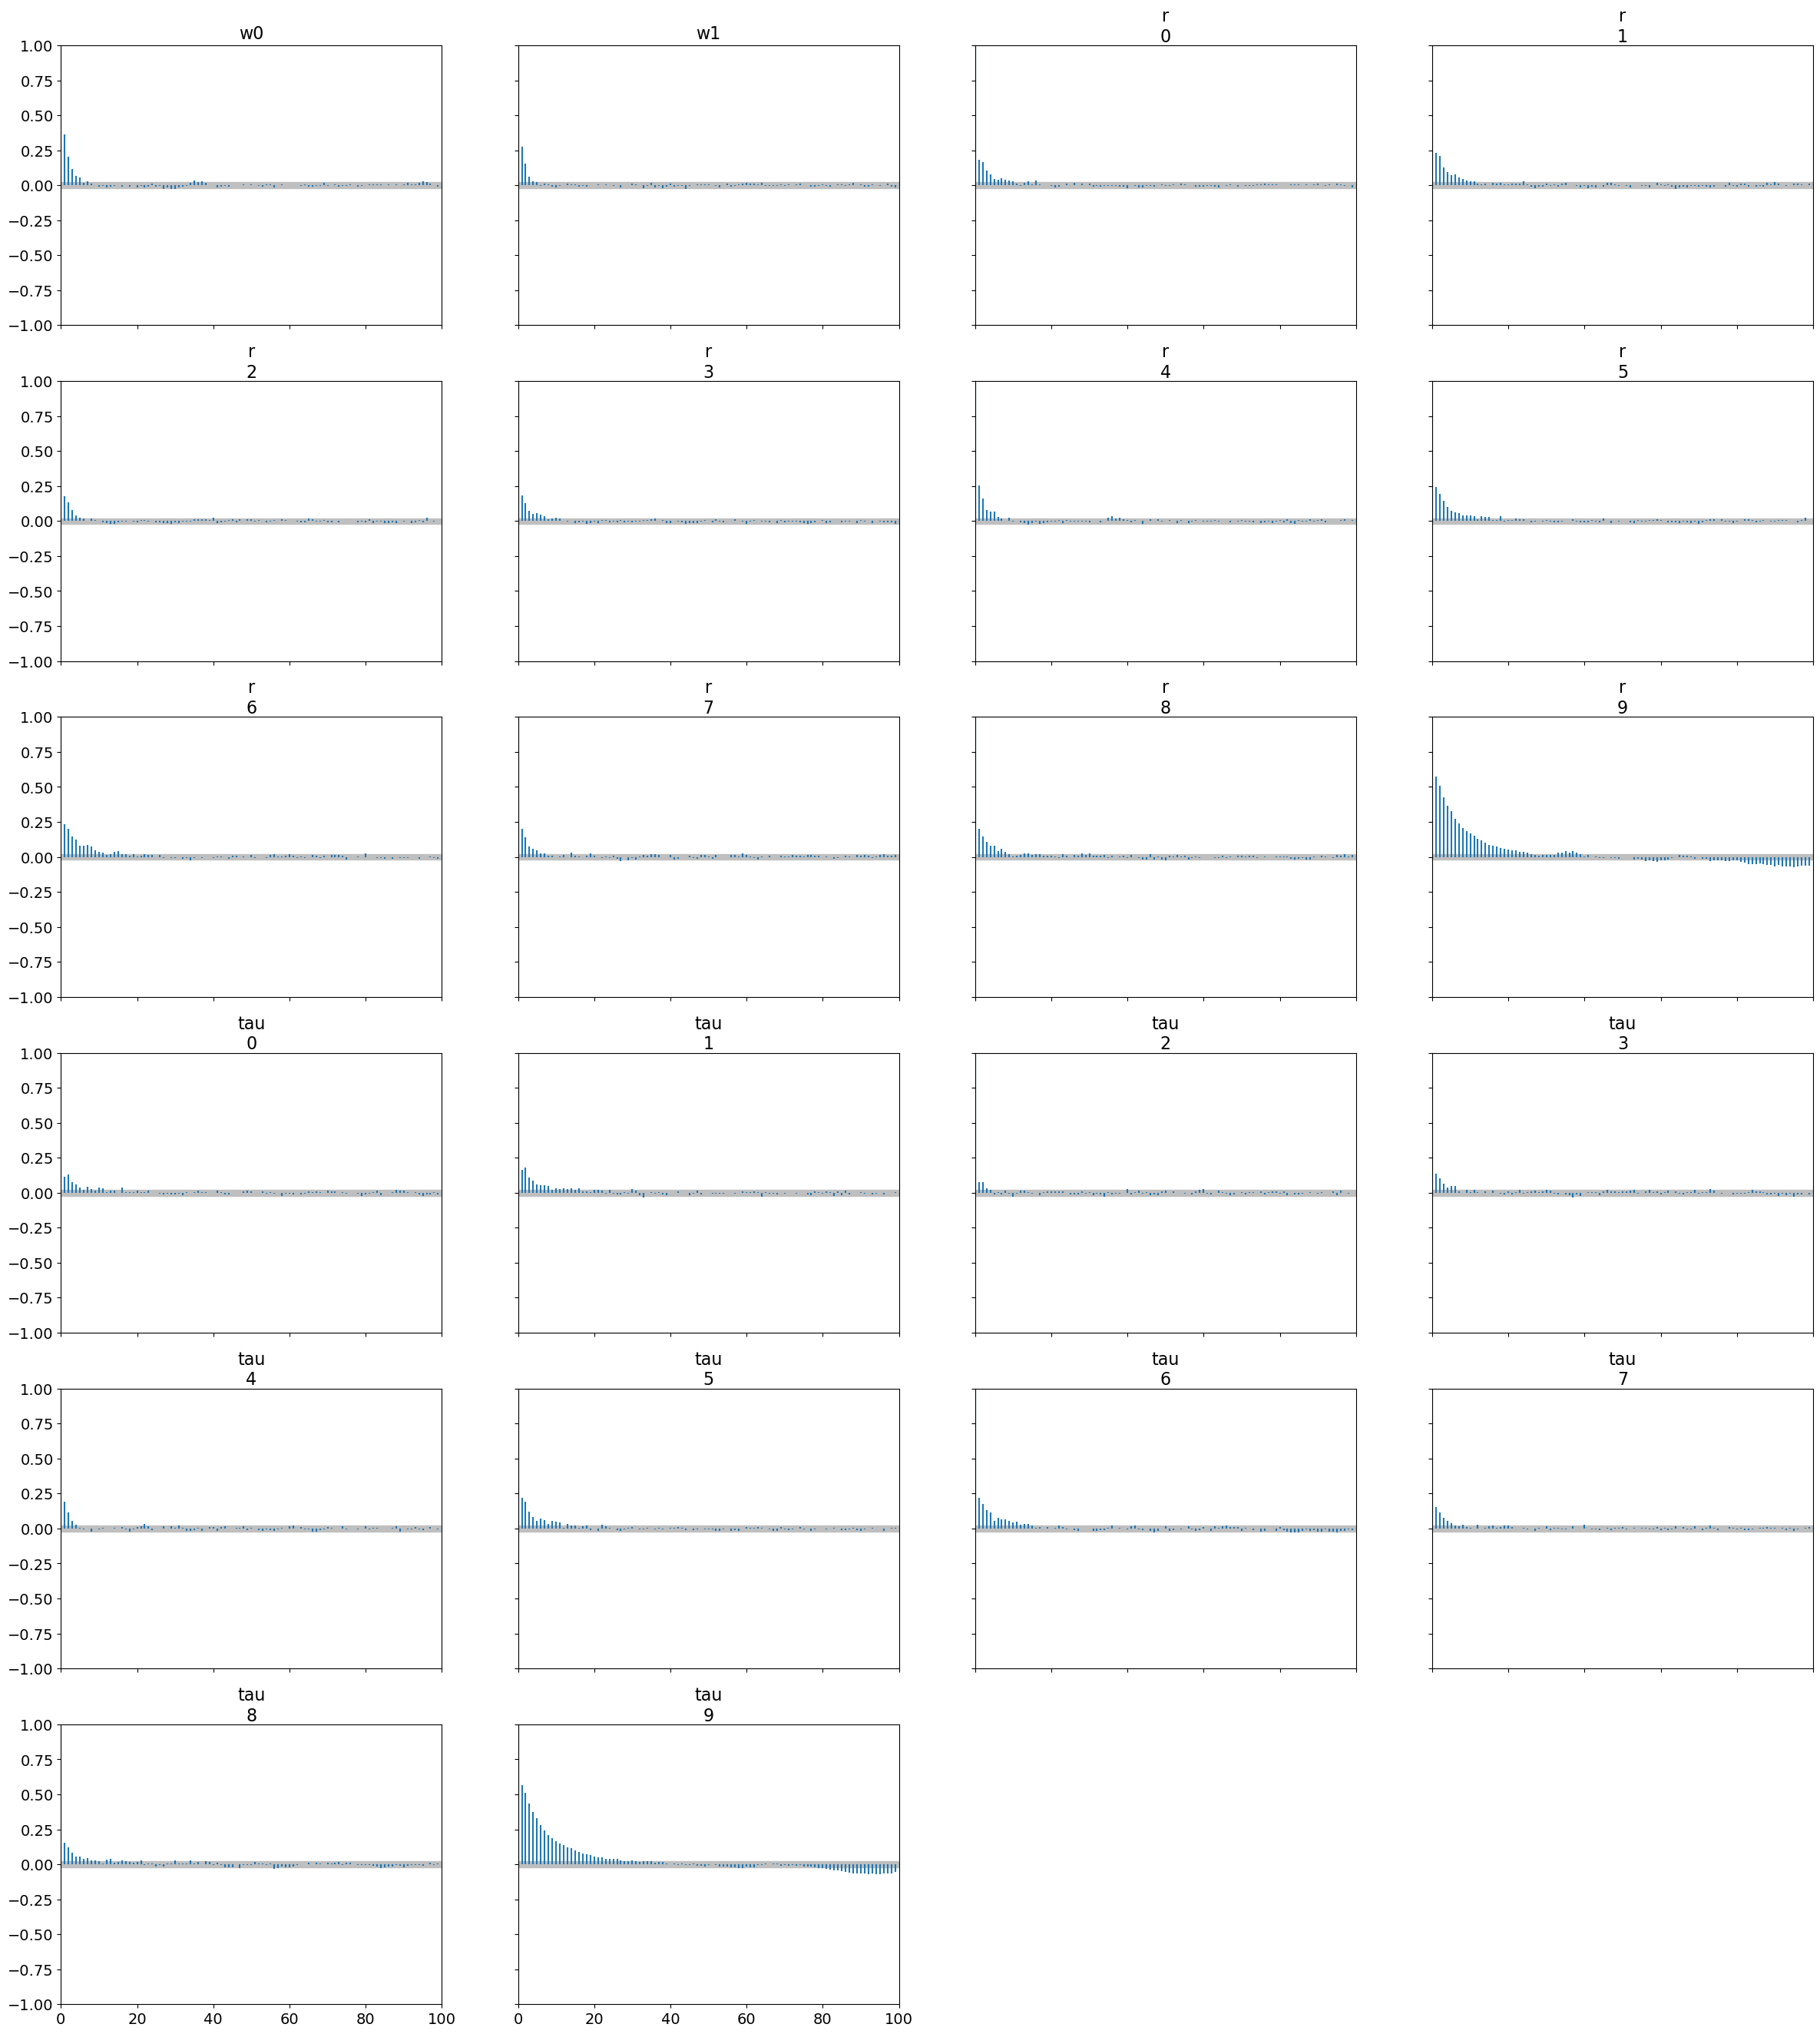

In [476]:
summary = az.summary(trace, var_names=["w0", "w1", "r", "tau"])
display(summary)

az.plot_trace(trace, var_names=["w0", "w1", "r", "tau"], compact=False)
plt.tight_layout()

az.plot_autocorr(trace, var_names=["w0", "w1", "r", "tau"], combined=True)
plt.show()

$r_9, \tau_9$は他の釣り人に比べ、データが少ないので事後分布の分散が大きいことがわかる。

In [479]:
posterior = trace.posterior

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


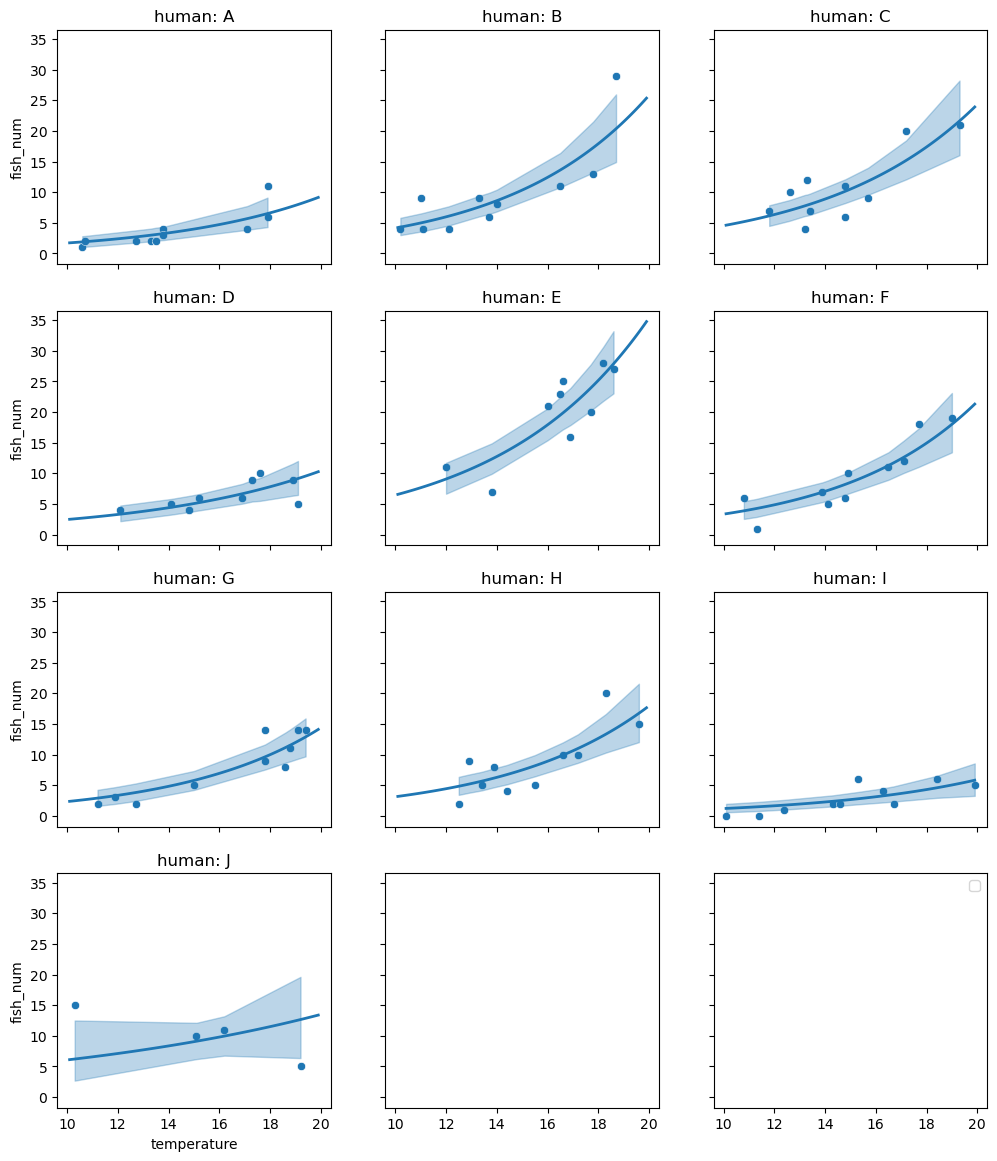

In [481]:
temp_values = np.linspace(temp.min(), temp.max(), 100)
cmap = plt.get_cmap("tab10")

w0_mean = summary['mean'].w0
w1_mean = summary['mean'].w1

hdis = az.hdi(posterior, hdi_prob=0.95)["mu"].values

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 14), sharex=True, sharey=True)
axes = axes.reshape(-1)

for i, h in enumerate(fish_num.human.unique()):
    human_idx = fish_num.human==h
    human_temp = temp[human_idx]
    temp_idx = np.argsort(human_temp)
    tau_mean = summary['mean'][f'tau[{i}]']
    r_mean = summary['mean'][f'r[{i}]']
    # 各天気の回帰曲線
    mean_reg = np.exp(w0_mean + w1_mean*temp_values + tau_mean*temp_values + r_mean)

    # 各天気の95% HDI
    hdi_human = hdis[human_idx][temp_idx]
    
    human_fish = fish_num[human_idx]
    sns.scatterplot(x='temperature', y='fish_num', data=human_fish, ax=axes[i])    # 観測値の散布図
    
    axes[i].set_title(f"human: {h}")

    # 回帰曲線のプロット
    axes[i].plot(temp_values, mean_reg, lw=2, c=cmap(0), label='cloudy regression line')

    # 95% HDIのプロット
    axes[i].fill_between(human_temp[temp_idx], y1=hdi_human[:,0], y2=hdi_human[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy")
   #axes[i].fill_between(temp_values, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny")
plt.legend()
plt.show()

このようにJさんについてベイズ信用区間の幅が広くなった。

### 階層化によるモデル化(pystan)

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

import stan
import nest_asyncio
nest_asyncio.apply()

In [2]:
fish_num = pd.read_csv('../data/3-3-fish-num.csv')

In [3]:
fish_num.sort_values(["human", "temperature"], inplace=True)
fish_num

fish_num  temperature human
9          1         10.6     A
54         2         10.7     A
0          2         12.7     A
63         2         13.3     A
72         2         13.5     A
..       ...          ...   ...
17         5         19.9     I
90        15         10.3     J
91        10         15.1     J
92        11         16.2     J
93         5         19.2     J

[94 rows x 3 columns]

In [4]:
y = fish_num['fish_num'].values
temp = fish_num['temperature'].values
X = np.hstack([np.ones((len(y), 1)), temp.reshape(-1,1)])

In [5]:
le = LabelEncoder()
human_id = le.fit_transform(fish_num["human"].values)+1

In [6]:
temp_pred = np.tile(np.linspace(temp.min(), temp.max(), 50), 10)
X_pred = np.hstack([np.ones((len(temp_pred), 1)), temp_pred.reshape(-1,1)])

In [7]:
human_id_pred = np.tile(np.unique(human_id), (50,1)).T.flatten()

In [8]:
stan_data = {
    "N": len(y),
    "K": X.shape[1],
    "N_human": len(np.unique(human_id)),
    "y": y,
    "X": X,
    "human_id": human_id,
    "N_pred": len(X_pred),
    "X_pred": X_pred,
    "human_id_pred": human_id_pred
}

In [9]:
with open('../stan/3-1-4-glmm-random-coef.stan') as f:
    stan_code = f.read()

In [10]:
sm = stan.build(stan_code, data=stan_data, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [11]:
fit = sm.sample(num_chains=3, num_samples=6000, num_warmup=1000, num_thin=2)

Sampling:   0%
Sampling:   0% (100/21000)
Sampling:   2% (400/21000)
Sampling:   2% (401/21000)
Sampling:  35% (7301/21000)
Sampling:  67% (14001/21000)
Sampling: 100% (21000/21000)
Sampling: 100% (21000/21000), done.
Messages received during sampling:
  Gradient evaluation took 5.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
  Adjust your expectations accordingly!


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0] -0.480  0.423  -1.259    0.335      0.006    0.004    5720.0   
beta[1]  0.162  0.024   0.118    0.206      0.000    0.000    6059.0   
r[0]    -0.697  0.628  -1.969    0.384      0.009    0.007    5344.0   
r[1]     0.073  0.516  -0.962    0.989      0.007    0.005    4929.0   
r[2]     0.316  0.514  -0.692    1.316      0.006    0.005    6762.0   
r[3]    -0.061  0.609  -1.195    1.156      0.008    0.006    6552.0   
r[4]     0.644  0.537  -0.385    1.649      0.007    0.005    6416.0   
r[5]    -0.180  0.583  -1.390    0.802      0.009    0.006    4058.0   
r[6]    -0.477  0.625  -1.770    0.575      0.010    0.007    4415.0   
r[7]    -0.137  0.559  -1.261    0.887      0.008    0.006    5492.0   
r[8]    -0.950  0.670  -2.276    0.243      0.009    0.007    5636.0   
r[9]     1.463  1.060  -0.179    3.369      0.027    0.019    1419.0   
t[0]     0.008  0.037  -0.059    0.084      0.001    0.000    5727.0   
t[1]     0.021  0.031  -0.033    0.083      0.000    0.000    4357.0   
t[2]     0.006  0.030  -0.054    0.061      0.000    0.000    6274.0   
t[3]    -0.018  0.035  -0.086    0.049      0.001    0.000    5447.0   
t[4]     0.009  0.030  -0.049    0.069      0.000    0.000    6007.0   
t[5]     0.025  0.034  -0.031    0.098      0.001    0.000    3839.0   
t[6]     0.019  0.035  -0.037    0.092      0.001    0.000    4551.0   
t[7]     0.013  0.032  -0.045    0.079      0.000    0.000    5661.0   
t[8]    -0.002  0.038  -0.072    0.074      0.001    0.000    5854.0   
t[9]    -0.080  0.066  -0.202    0.011      0.002    0.001    1310.0   

         ess_tail  r_hat  
beta[0]    6225.0    1.0  
beta[1]    6118.0    1.0  
r[0]       5554.0    1.0  
r[1]       6531.0    1.0  
r[2]       5921.0    1.0  
r[3]       5906.0    1.0  
r[4]       5943.0    1.0  
r[5]       5992.0    1.0  
r[6]       5831.0    1.0  
r[7]       5807.0    1.0  
r[8]       5206.0    1.0  
r[9]       4630.0    1.0  
t[0]       5308.0    1.0  
t[1]       6339.0    1.0  
t[2]       5821.0    1.0  
t[3]       5776.0    1.0  
t[4]       5690.0    1.0  
t[5]       5625.0    1.0  
t[6]       6066.0    1.0  
t[7]       6168.0    1.0  
t[8]       5842.0    1.0  
t[9]       3466.0    1.0

/usr/local/lib/python3.11/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


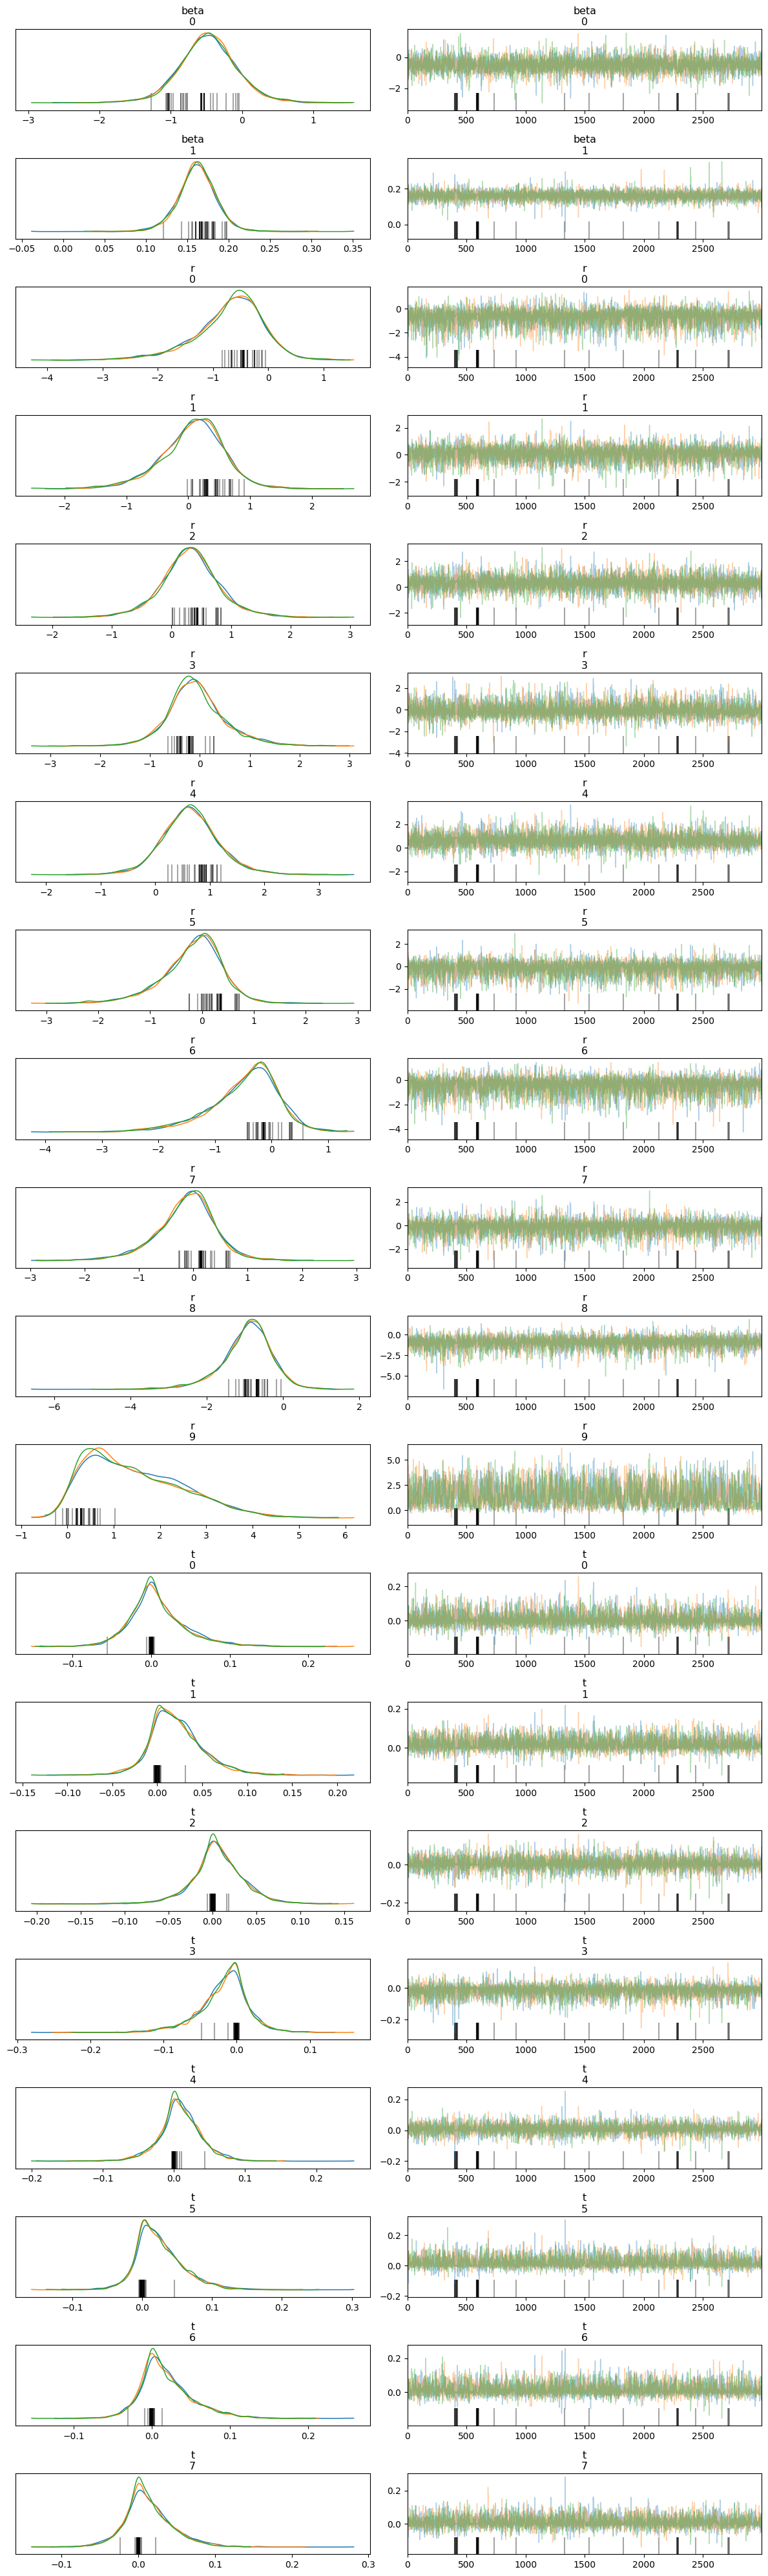

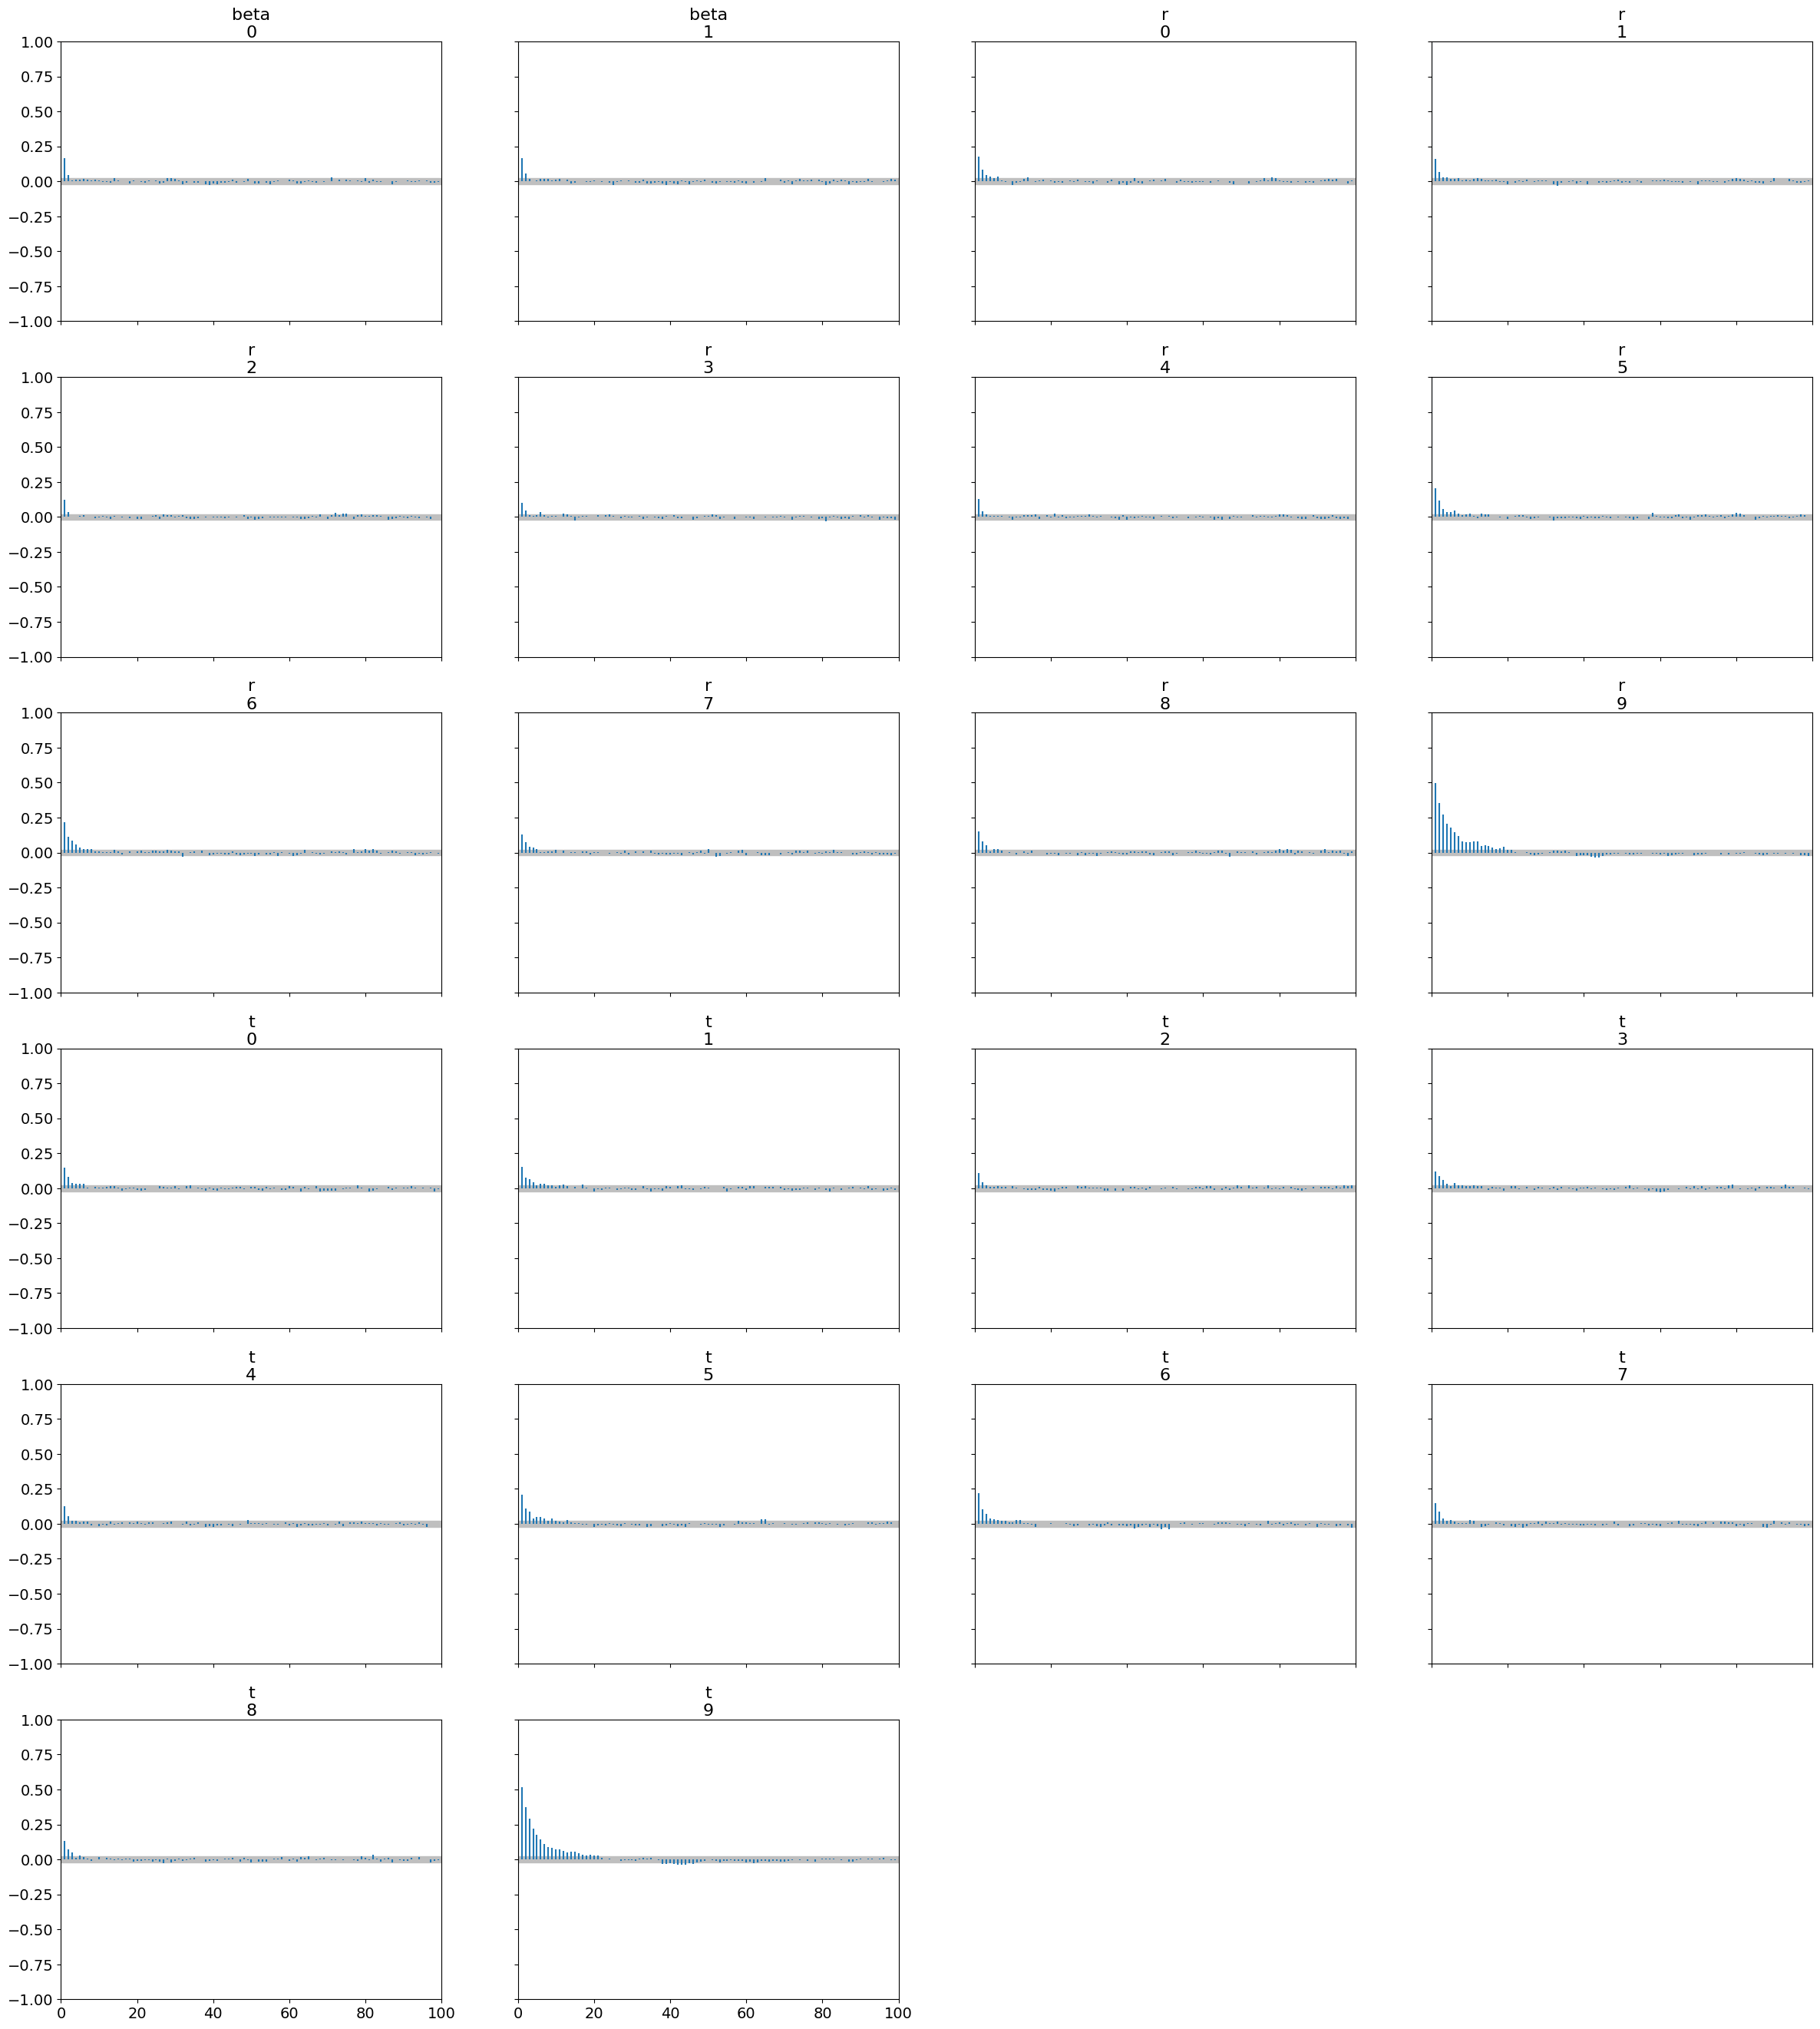

In [15]:
summary = az.summary(fit, var_names=["beta", "r", "t"])
display(summary)

az.plot_trace(fit, var_names=["beta", "r", "t"], compact=False)
plt.tight_layout()

az.plot_autocorr(fit, var_names=["beta", "r", "t"], combined=True)
plt.show()

In [ ]:
temp_pred = np.tile(np.linspace(temp.min(), temp.max(), 50), 10)
X_pred = np.hstack([np.ones((len(temp_pred), 1)), temp_pred.reshape(-1,1)])
human_id_pred = np.tile(np.unique(human_id), (50,1)).T.flatten()

In [ ]:
cmap = plt.get_cmap("tab10")

sunny_idx = X_pred[:,1] == 1
cloudy_idx = X_pred[:,1] == 0

beta_mean = az.summary(fit, var_names=["beta"])["mean"].values
means = np.dot(X_pred, beta_mean)

hdis = az.hdi(fit, hdi_prob=0.95)["lambda_pred"].values

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(28, 12), sharex=True, sharey=True)
axes = axes.reshape(-1)

for i, h in enumerate(np.unique(human_id_pred)):
    human_idx = human_id_pred == h
    human_r_mean = summary['mean'][f'r[{i}]']
    sunny_mean = means[sunny_idx & human_idx]
    cloudy_mean = means[cloudy_idx & human_idx]
    temp_values = temp_pred[sunny_idx & human_idx]
    
    # 各天気の回帰曲線
    sunny_reg = np.exp(sunny_mean + human_r_mean)
    cloudy_reg = np.exp(cloudy_mean + human_r_mean)

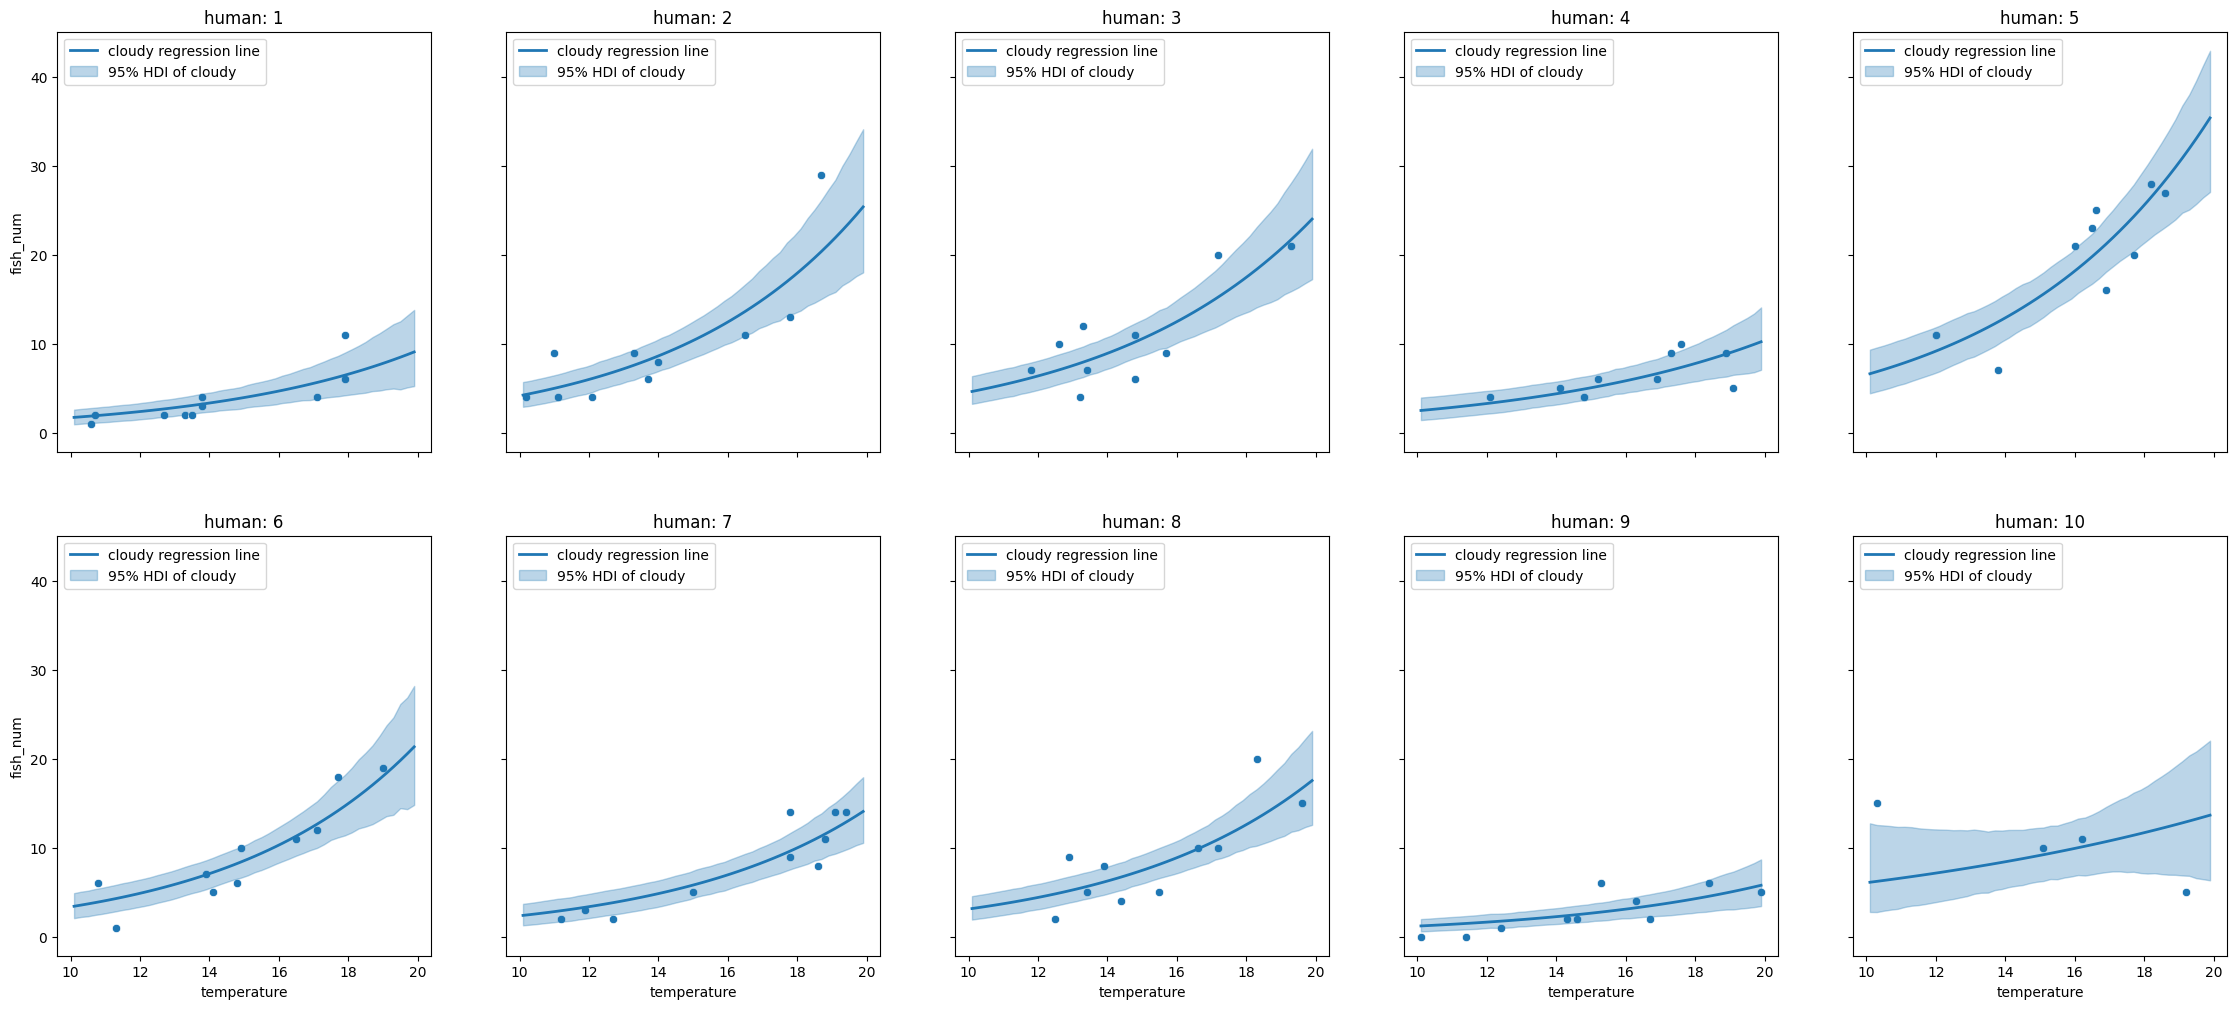

In [32]:
cmap = plt.get_cmap("tab10")

beta_mean = az.summary(fit, var_names=["beta"])["mean"].values
means = np.dot(X_pred, beta_mean)

hdis = az.hdi(fit, hdi_prob=0.95)["lambda_pred"].values

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(28, 12), sharex=True, sharey=True)
axes = axes.reshape(-1)

for i, h in enumerate(np.unique(human_id_pred)):
    human_idx = human_id_pred==h
    human_t_mean = summary['mean'][f't[{i}]']
    human_r_mean = summary['mean'][f'r[{i}]']
    human_X = X_pred[human_idx]
    human_temp = human_X[:,1]
    # 各天気の回帰曲線
    mean_reg = np.exp(np.dot(human_X, beta_mean) + human_temp * human_t_mean + human_r_mean)

    # 各天気の95% HDI
    hdi_human = hdis[human_idx]
    
    human_fish = fish_num[human_id == h]
    sns.scatterplot(x='temperature', y='fish_num', data=human_fish, ax=axes[i])    # 観測値の散布図
    
    axes[i].set_title(f"human: {h}")

    # 回帰曲線のプロット
    axes[i].plot(human_temp, mean_reg, lw=2, c=cmap(0), label='cloudy regression line')

    # 95% HDIのプロット
    axes[i].fill_between(human_temp, y1=hdi_human[:,0], y2=hdi_human[:,1], color=cmap(0), alpha=0.30, label="95% HDI of cloudy")
   #axes[i].fill_between(temp_values, y1=hdi_sunny[:,0], y2=hdi_sunny[:,1], color=cmap(1), alpha=0.30, label="95% HDI of sunny")
    axes[i].legend(loc='upper left')
plt.show()